\[ Stefano Pigozzi | Tema Data Analytics | Big Data Analytics | A.A. 2022/2023 | Unimore \]

In [1]:
%load_ext autoreload
%autoreload 2

# Ricerca di correlazioni nell'attività online relativa a videogiochi pubblicati sulla piattaforma Steam

> ### Data processing e exploratory data analytics su dataset provenienti da più sorgenti
>
> L’attività da svolgere consiste nel:
>
> 1. Scegliere due o più dataset provenienti da due o più sorgenti.
>     * Il dataset finale deve essere costituito almeno da due file.
> 2. Usando [pandas](https://pandas.pydata.org/) implementare le operazioni di data processing necessarie (principalmente join e selezioni) per mettere in collegamento i dataset e per preparare i dati al passo successivo
> 3. Usando pacchetti Python quali [pandas](https://pandas.pydata.org/), [scipy](https://scipy.org/), [matplotlib](https://matplotlib.org/) e [seaborn](https://seaborn.pydata.org/) implementare attività di data cleaning, exploratory data analysis estraendo dati statistici e di visualizzazione dei risultati attraverso il quale sia possibile "raccontare qualcosa sui dati" (storytelling), eventualmente partendo da dei quesiti di ricerca.
>    L'uso dei pacchetti non deve necessariamente essere limitato alle istruzioni viste a lezione. Le documentazioni dei pacchetti stessi e i volumi messi a disposizione su Dolly fornisco spunti d’uso interessanti!
> 4. Produrre un notebook [Jupyter](https://jupyter.org/) che contenga:
>     * una introduzione all’argomento scelto, alle sorgenti dati e agli obiettivi del progetto specificando eventualmente i quesiti di ricerca
>     * una sezione per ogni fase del progetto di data analytics

## Sinossi

In questa relazione si ricercano correlazioni tra vari parametri relativi all'attività online riguardante vari videogiochi per PC pubblicati sulla piattaforma di distribuzione [Steam](https://store.steampowered.com/), recuperando dati da varie fonti, quali la web API di [Steam](https://store.steampowered.com/) stesso, il progetto [SteamDB](https://steamdb.info/), il catalogo prezzi [IsThereAnyDeal](https://isthereanydeal.com/), e [Google Trends](https://trends.google.com/trends/), costruendo infine un funzione con discreta correlazione con il numero di giocatori attivi in un determinato giorno.

## Introduzione

[Steam](https://store.steampowered.com/) è una piattaforma di vendita e distribuzione videogiochi per PC creata da [Valve Corporation](https://www.valvesoftware.com/en/).

[Valve Corporation](https://www.valvesoftware.com/en/) pubblica quotidianamente [dati sul numero massimo di giocatori concorrenti](https://store.steampowered.com/charts/) di ciascun videogioco; questi dati vengono raccolti dal progetto indipendente [SteamDB](https://steamdb.info/), che li utilizza per mostrare la popolarità storica di ciascun prodotto.

Periodicamente, i videogiochi disponibili su [Steam](https://store.steampowered.com/) vengono scontati temporaneamente per incentivare gli utenti della piattaforma ad acquistarli; ciò in genere avviene tra le due e le cinque volte all'anno, principalmente nel periodo natalizio e attorno al solstizio di estate.

Il progetto [SteamDB](https://steamdb.info/) monitora quotidianamente i prezzi di ciascun prodotto, aggregandoli per creare uno storico complessivo dei prezzi.

I videogiochi presenti su [Steam](https://store.steampowered.com/) possono essere anche acquistati attraverso siti di terze parti, che possono offrire prezzi o offerte diversi da quelli della piattaforma, pur sempre condividendone i servizi, come ad esempio [Humble Bundle](https://www.humblebundle.com/); il catalogo prezzi [IsThereAnyDeal](https://isthereanydeal.com/) si occupa di controllare periodicamente i prezzi su ciascun rivenditore e di aggregarli in un sito unico, creando poi uno storico globale dei prezzi migliori.

Gli sviluppatori dei videogiochi su [Steam](https://store.steampowered.com/) possono pubblicare periodicamente sulla piattaforma degli annunci relativi al proprio videogioco, tipicamente per informare i clienti della disponibilità di una nuova release.

Gli annunci pubblicati da ciascun prodotto sono recuperabili attraverso chiamate ad una [web API](https://developer.valvesoftware.com/wiki/Steam_Web_API#GetNewsForApp_.28v0002.29) pubblica.

## Obiettivo dell'indagine

La popolarità di un videogioco è una metrica sociale, alimentata da tanti diversi fattori, che possono variare anche significativamente in base al genere in questione.

Si ipotizza che uno di questi fattori sia la presenza di sconti, in quanto si è empiricamente notato che il numero di giocatori sembra aumentare in presenza di essi.

Si ipotizza inoltre che il rilascio di nuovi contenuti porti a un picco improvviso seguito da una lenta diminuzione nel numero di giocatori concorrenti, circa corrispondente al tempo necessario per vedere le novità.

In questa indagine, si vuole provare a modellare una funzione che, utilizzando solo parametri esterni, ottenga una discreta correlazione con il numero di giocatori concorrenti di ciascun videogioco (senza ricorrere a tecniche di machine learning).

## Oggetto dell'indagine

Recuperare grandi quantità di dati relative a un vasto numero di prodotti diversi è difficoltoso, in quanto tutte le fonti che si desidera utilizzare implementano misure per prevenire lo scraping automatizzato.

Inoltre, la moltitudine di generi di videogiochi esistenti e di stili di comunicazione adottati dagli sviluppatori può introdurre notevole rumore e rendere questo studio impossibile. 

Si decide pertanto di concentrarsi esclusivamente sui prodotti con le seguenti caratteristiche:

- ne è stata rilasciata la versione 1.0
- non hanno fattori fortemente sociali come origine della loro popolarità
    - la loro componente principale non è il multigiocatore competitivo
- vengono scontati regolarmente
- non abusano della funzionalità di annunci per pubblicare informazioni non riguardanti il prodotto
- hanno venduto un numero significativo di copie
    - hanno almeno 10000 recensioni pubblicate dai clienti

Si recupera quindi manualmente un piccolo sottoinsieme di dataset relativi a diversi prodotti con le caratteristiche indicate nella sezione precedente, descrivendo però accuratamente il metodo utilizzato per recuperare i dati in modo da poter estendere riproducibilmente la ricerca a qualsiasi altro prodotto.

I prodotti selezionati sono:

- [Deep Rock Galactic](https://steamdb.info/app/548430/)
- [OMORI](https://steamdb.info/app/1150690/)
- [Potion Craft: Alchemist Simulator](https://steamdb.info/app/1210320/)
- [Untitled Goose Game](https://steamdb.info/app/837470/)

In più, al fine di mostrare quanta differenza può esserci tra un prodotto e l'altro, si recuperano anche dati relativi a questo videogioco, che non presenta le caratteristiche sopraelencate:

- [Factorio](https://steamdb.info/app/427520/)
    - non è mai stato scontato
    - ha pubblicato per anni nella sezione annunci un diario settimanale dello sviluppo
    - viene aggiornato regolarmente, ma solo per correzione di bug, e non per l'aggiunta di nuovi contenuti

## Struttura del progetto

Il progetto è diviso in tre parti:

- la directory `data` con i dati grezzi recuperati dalla rete, con a sua volta tante sottodirectory con i dati specifici di ciascun prodotto studiato;
- il package Python `unimore_bda_3`, contenente primitive specifiche all'elaborazione dei dati;
- questo notebook Jupyter, contenente celle per la rappresentazione dei dati elaborati.

Il package contiene un modulo particolare, `unimore_bda_3.prelude`, che importa tutte le dipendenze necessarie allo svolgimento dell'analisi e le ri-esporta con degli alias semplici e intuitivi.

Il package è compatibile con PEP518; per installarlo, è necessario eseguire i seguenti comandi dalla directory del progetto:

```bash
python3 -v venv .venv
source venv/bin/activate  # Assumendo l'utilizzo di Bash
pip install .
```

Si importa il modulo all'interno del notebook, in modo da avere tutti gli alias disponibili:

In [2]:
from unimore_bda_3.prelude import *

## Recupero manuale dei dati

In questa sezione si recuperano manuale dati machine-readable da diverse fonti indipendenti fra loro, evitando di incappare in protezioni automatizzate insuperabili come CAPTCHA.

### [Google Trends](https://trends.google.com/trends/)

Si cercano su Google Trends i prodotti oggetto di questa ricerca, facendo attenzione a selezionare l'*argomento "Videogioco"* e non il *termine di ricerca* con lo stesso nome per minimizzare i falsi positivi.

![Visualizzazione di come effettuare una ricerca su Google Trends attraverso interfaccia grafica.](media/google-trends-query.png)

Si configura poi la ricerca perchè sia relativa a *Tutto il mondo* e nell'arco di tempo *2004 - Presente*, in modo da avere dati generali relative alle tendenze globali, e poi si utilizza il pulsante *Download* per scaricare il file CSV relativo all'*Interesse nel tempo*.

![Visualizzazione di come configurare i parametri di una ricerca su Google Trends attraverso interfaccia grafica, e di come scaricarne i risultati.](media/google-trends-parameters.png)

I file CSV così recuperati sono inseriti al percorso `data/{nome}/gtrends-worldwide.csv`.

### [SteamDB](https://steamdb.info/)

Si cercano su SteamDB i prodotti oggetto della ricerca.

![Visualizzazione di come effettuare una ricerca su SteamDB attraverso interfaccia grafica.](media/steamdb-search.png)

Dalla pagina di ciascun prodotto si recupera l'App ID, un codice univoco utilizzato da Steam per identificare il software, e lo si salva all'interno del file `data/{nome}/steam_appid.txt`.

![Visualizzazione di come recuperare l'App ID di un prodotto dalla relativa pagina SteamDB.](media/steamdb-appid.png)

Si accede poi alla scheda *Price History*.

![Visualizzazione di come accedere alla scheda Price History.](media/steamdb-tab-price-history.png)

In fondo ad essa, nella omonima sezione, è presente un grafico dello storico prezzi, con a destra un bottone per il download del dataset.

![Visualizzazione di come scaricare il dataset dello storico prezzi.](media/steamdb-chart-price-history.png)

Il file recuperato viene salvato con il nome `data/{nome}/steamdb-price.csv`.

Si accede poi alla scheda *Charts*.

![Visualizzazione di come accedere alla scheda Charts.](media/steamdb-tab-charts.png)

Poco sotto la selezione, si trova la sezione *Lifetime player count history*, contenente un grafico dello storico del numero di giocatori concorrenti dalla comparsa del prodotto su Steam, con a destra un bottone per il download del dataset.

![Visualizzazione di come scaricare il dataset dello storico prezzi.](media/steamdb-chart-player-history.png)

Il file recuperato viene salvato con il nome `data/{nome}/steamdb-players.csv`.


### [IsThereAnyDeal](https://isthereanydeal.com/)

Si cercano sul sito `https://new.isthereanydeal.com` i cinque prodotti relativi a questa ricerca.

![Visualizzazione di come cercare prodotti su IsThereAnyDeal.](media/itad-search.png)

Si accede alla scheda *History*, e si utilizza il tool *Ispeziona Elemento* del browser Firefox per accedere al sorgente HTML della pagina dopo che essa ha eseguito il codice JavaScript necessario per la visualizzazione dei grafici.

![Visualizzazione di come ispezionare il grafico nei Firefox Developer Tools.](media/itad-inspect-element.png)

Dal grafico, si risale la gerarchia degli elementi fino ad arrivare a un `<div>` con la classe `.js-chart-container`.

![Visualizzazione del .js-chart-container nei Firefox Developer Tools.](media/itad-jschartcontainer.png)

Immediatamente dopo, è presente uno `<script>`.
Ne si selezionano i contenuti, e li si salvano all'interno del file `data/{nome}/itad-price.js`.

![Visualizzazione del tag script.](media/itad-script-scraping.png)

## Importazione dei dati

In questa sezione si descrive come caricare nel notebook i dati ottenuti manualmente, recuperandone automaticamente altri, convertendoli in `pd.DataFrame`, uniformandoli e rendendoli human-friendly.

Per ciascun dataset grezzo si è creato un modulo `unimore_bda_3.loaders.*` in grado di convertirlo in un `pd.DataFrame`.

Si importano tutti i loader all'interno di questo notebook Jupyter, raccolti all'interno della variabile `loaders`.

In [3]:
from unimore_bda_3 import loaders

### Importazione dati di Google Trends - `unimore_bda_3.loaders.gtrends`

Il *loader* dei dati di Google Trends utilizza la funzione `pd.read_csv` per trasformare il file comma-separated values direttamente in un `pd.DataFrame`.

```python
dataframe = pd.read_csv(fd, sep=",", header=1)
```

Utilizzando il kwarg `header`, Pandas è in grado di ignorare la riga di prefazione che Google Trends inserisce nei file scaricati:

```csv
Categoria: Tutte le categorie

Mese,Deep Rock Galactic: (Tutto il mondo)
2004-01,0
2004-02,0
2004-03,0
```

Inoltre, il loader pulisce il dataset, effettuando i seguenti passi:

1. rinomina le colonne, assegnando loro un titolo più human-friendly:

    ```python
    dataframe.rename(inplace=True, columns={
        "Mese": "Date",
        f"{query_name}: (Tutto il mondo)": "Google Trends · Score",
    })
    ```

2. converte in date le stringhe presenti nella colonna dell'indice:

    ```python
    dataframe["Date"] = pd.to_datetime(dataframe["Date"])
    ```

3. converte in interi i numeri presenti nella colonna dei valori, trasformando in `0` i valori `"< 1"`, e scalando i valori da 0-100 a 0-1:

    ```python
    dataframe["Google Trends · Score"] = dataframe["Google Trends · Score"].map(lambda x: int(x) if x != "< 1" else 0) / 100
    ```

4. imposta la colonna delle date come indice del dataframe:

    ```python
    dataframe.set_index("Date", inplace=True)
    ```


Si verifica il corretto funzionamento del loader con questa chiamata ad esso:

In [4]:
with open("./data/deeprockgalactic/gtrends-worldwide.csv") as fd:
    df = loaders.gtrends.load(fd, "Deep Rock Galactic")
df


,Google Trends · Score
Date,
2004-01-01,0.00
2004-02-01,0.00
2004-03-01,0.00
2004-04-01,0.00
2004-05-01,0.01
...,...
2023-02-01,0.40
2023-03-01,0.56
2023-04-01,0.41


### Importazione dati da SteamDB - `unimore_bda_3.loaders.steamdb`

I due *loader* dei dati da SteamDB funzionano in modo molto simile a quello di Google Trends, in quanto anch'esso usa `pd.read_csv`.

```python
dataframe = pd.read_csv(fd, sep=",")
```

Allo stesso modo, puliscono il dataset in un modo molto simile:

```python
dataframe.rename(inplace=True, columns={
    "DateTime": "Date",
    "Players": "SteamDB · Peak concurrent players",
    "Average Players": "SteamDB · Day average of concurrent players",
    "Flags": "SteamDB · Player count flags",
})

dataframe["Date"] = pd.to_datetime(dataframe["Date"])

dataframe.set_index("Date", inplace=True)
```

```python
dataframe.rename(inplace=True, columns={
    "DateTime": "Date",
    "Final price": "SteamDB · Steam",
    "Flags": "SteamDB · Price flags",
})

dataframe["Date"] = pd.to_datetime(dataframe["Date"])

dataframe.set_index("Date", inplace=True)
```

Si ha però una differenza significativa, che consiste nel raccoglimento dei valori per data, in quanto i dataset contengono anche gli orari di registrazione dei dati, che ai fini di questa ricerca possono essere ignorati.

```python
dataframe = dataframe.groupby(dataframe.index.date).max()
dataframe.index = pd.to_datetime(dataframe.index)
```

```python
dataframe = dataframe.groupby(dataframe.index.date).min()
dataframe.index = pd.to_datetime(dataframe.index)
```

Si verifica il corretto funzionamento dei loader con queste chiamate ad essi:

In [5]:
with open("./data/deeprockgalactic/steamdb-players.csv") as fd:
    df = loaders.steamdb.load_players(fd)
df

,SteamDB · Peak concurrent players,SteamDB · Day average of concurrent players,SteamDB · Player count flags
2016-12-01,11.0,NaN,NaN
2016-12-02,NaN,NaN,NaN
2016-12-03,NaN,NaN,NaN
2016-12-04,NaN,NaN,NaN
2016-12-05,NaN,NaN,NaN
...,...,...,...
2023-06-25,35016.0,26276.0,NaN
2023-06-26,30017.0,22421.0,NaN
2023-06-27,29568.0,21949.0,NaN
2023-06-28,28539.0,21347.0,NaN


In [6]:
with open("./data/deeprockgalactic/steamdb-price.csv") as fd:
    df = loaders.steamdb.load_price(fd)
df

,SteamDB · Steam,SteamDB · Price flags
2018-02-28,22.99,NaN
2018-04-24,20.69,NaN
2018-04-27,22.99,NaN
2018-05-10,17.24,NaN
2018-05-14,22.99,NaN
...,...,...
2023-03-23,29.99,NaN
2023-04-20,9.89,NaN
2023-05-04,29.99,NaN
2023-06-15,9.89,NaN


### Importazione dati da IsThereAnyDeal - `unimore_bda_3.loaders.itad`

Il *loader* dei dati da IsThereAnyDeal ricerca i dataset JSON contenuti all'interno del codice JavaScript del sito web, utilizzati per generare dinamicamente i grafici che esso mostra.

La regular expression utilizzata è la seguente:

```python
PRICE_REGEX = re.compile(r"""Charts[.]Builder[(]setup, (.+?)[)]""")
```

Per ciascun dataset trovato, il loader chiama un'altra funzione, adibita a convertirlo in un `pd.DataFrame`:

```python
matches: list[str] = PRICE_REGEX.findall(data)

return [_load_price_dataframe(match) for match in matches]
```

La funzione di conversione a `pd.DataFrame` carica il dataset JSON con la funzione `json.loads`, poi per ciascuna serie presente all'interno di esso chiama un'ulteriore funzione che si occupa di convertirla in una `pd.Series`.

```python
srcs: list = json.loads(match)

dataframe = pd.DataFrame(
    data=[_load_price_series(src) for src in srcs]
).T

dataframe.index = pd.to_datetime(dataframe.index)

return dataframe
```

La funzione di conversione a `pd.Series` converte le tuple `(indice, valore)` in due liste contenente tutti gli indici e tutti i valori, il formato richiesto da Pandas.

```python
index = [pd.Timestamp(item[0], unit="ms", tz="utc") for item in src["data"]]
data = [item[1] for item in src["data"]]

series = pd.Series(
    data=data,
    index=index,
    name=f"""ITAD · {src["name"]}"""
)

return series
```

Inoltre, effettua lo stesso raggruppamento già visto nel loader di SteamDB per selezionare solo la data e non l'ora di ciascun valore:

```python
if "Worst" in series.name or "High" in series.name:
    series = series.groupby(series.index.date).max()
else:
    series = series.groupby(series.index.date).min()
```


Si verifica il corretto funzionamento del loader con questa chiamata ad esso:

In [7]:
with open("./data/deeprockgalactic/itad-price.js") as fd:
    df = loaders.itad.load(fd)
df[0]


,ITAD · Best Price,ITAD · Best Regular Price,ITAD · Worst Regular Price,ITAD · Historical Low
2018-02-28,22.99,22.99,22.99,22.99
2018-04-24,20.69,22.99,22.99,20.69
2018-04-27,20.69,22.99,22.99,NaN
2018-05-10,17.24,22.99,22.99,17.24
2018-05-14,17.24,22.99,22.99,NaN
...,...,...,...,...
2023-05-04,9.89,29.99,29.99,NaN
2023-05-05,9.89,29.99,29.99,NaN
2023-05-23,9.89,29.99,29.99,NaN
2023-06-15,9.89,29.99,29.99,NaN


### Recupero e importazione dei dati degli annunci dalla web API di Steam - `unimore_bda_3.loaders.steam`

Il *loader* di dati da Steam non si basa su un dataset locale archiviato su file, bensì effettua dinamicamente richieste alla web API di Steam al fine di recuperare i dati più aggiornati disponibili relativi agli annunci di un prodotto con un dato app id.

A tale scopo, fa uso del package `httpx` per richieste HTTP:

```python
import httpx

steam_api = httpx.Client(base_url="https://api.steampowered.com")
```

Il loader legge dal relativo file l'app id del prodotto di cui caricare i dati, e procede a effettuare richieste HTTP per esso:

```python
appid = int(fd.read().strip())
data = fetch(appid=appid)

return data
```

Il recupero dei dati avviene in quattro fasi:

1. Vengono effettuate ripetute richieste all'API fino a quando non sono stati recuperati tutti gli annunci esistenti:

    ```python
    count = 100
    enddate = {}
    newsitems = []

    while count == 100:
        request = steam_api.get(
            "/ISteamNews/GetNewsForApp/v0002/",
            params={
                "appid": appid,
                "count": 100,
                "format": "json",
                **enddate,
            }
        )
        request.raise_for_status()
        data = request.json()["appnews"]
        count = len(data["newsitems"])
        newsitems.extend(data["newsitems"])
        enddate = {"enddate": newsitems[-1]["date"]}

    return newsitems
    ```

2. Gli annunci recuperati vengono categorizzati in base al tag ad essi associato dalla web API:

    ```python
    result = collections.defaultdict(list)

    for item in news:
        tags = item.get("tags", [])
        if tags:
            for tag in set(item.get("tags", [])):
                result[tag].append(item)
        else:
            result["no_tags"].append(item)

    return result
    ```

3. Il numero di annunci per ciascun tag in ciascun giorno viene raccolto in una `pd.Series`:

    ```python
    index = pd.to_datetime([datetime.fromtimestamp(item["date"]) for item in news])

    return pd.Series(
        data=[1 for _ in index],
        index=index,
        name=f"""Steam · Count of News tagged {name}""",
        dtype=np.uint8,
    )
    ```

4. Le `pd.Series` vengono unite in un dataframe unico, con i valori nulli riempiti a zero e i conteggi di annunci in una sola giornata ancora una volta raggruppati e sommati:

    ```python
    raw_news = _load_news(appid=appid)
    categorized_news = _categorize_news(news=raw_news)
    serialized_news = [_serialize_news(name=name, news=news).to_frame() for name, news in categorized_news.items()]

    dataframe = utils.join_frames(*serialized_news).fillna(0)
    dataframe = dataframe.groupby(dataframe.index.date).sum()
    dataframe.index = pd.to_datetime(dataframe.index)

    return dataframe
    ```

Si verifica il corretto funzionamento del loader con questa chiamata ad esso:

In [8]:
with open("./data/deeprockgalactic/steam_appid.txt") as fd:
    df = loaders.steam.load(fd)
df


,Steam · Count of News tagged no_tags,Steam · Count of News tagged patchnotes,Steam · Count of News tagged hide_store,Steam · Count of News tagged ModAct_1401078964_1677758714_0,Steam · Count of News tagged mod_require_rereview,Steam · Count of News tagged mod_reviewed,Steam · Count of News tagged steam_award_vote_request,Steam · Count of News tagged mod_hide_library_overview,Steam · Count of News tagged steam_award_nomination_request,Steam · Count of News tagged halloween,Steam · Count of News tagged hide_library_overview,Steam · Count of News tagged hide_library_detail,Steam · Count of News tagged halloween2019candidate,Steam · Count of News tagged auto_migrated
2016-12-15,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2017-02-17,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2017-02-23,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2017-03-23,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,5.0
2017-04-01,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-09,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-14,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-15,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-----

In [9]:
# Pulizia ambiente

try:
    del fd
except NameError:
    pass

try:
    del df
except NameError:
    pass

## Elaborazione dei dati - `unimore_bda_3.processing`

In questa sezione si descrive come elaborare i `pd.DataFrame` caricati per unificarli in uno unico molto più grande, più facile da visualizzare e manipolare.

Si crea un modulo Python chiamato `unimore_bda_3.processing` con tale scopo.

Lo si importa all'interno di questo notebook:

In [10]:
from unimore_bda_3 import processing

### Elaborazione dei dati di un singolo prodotto - `process_game`

Si definisce la funzione `process_game`, per raccogliere tutti i dati relativi a uno specifico videogioco in un unico `pd.DataFrame`, dato il suo titolo e il percorso alla cartella dei file contenenti i dataset.

```python
def process_game(name: str, path: Path) -> pd.DataFrame:
    ...
```

Come prima cosa, essa determina il percorso di ciascun singolo file da processare:

```python
steam_appid_path = path.joinpath("steam_appid.txt")
gtrends_worldwide_path = path.joinpath("gtrends-worldwide.csv")
steamdb_players_path = path.joinpath("steamdb-players.csv")
steamdb_price_path = path.joinpath("steamdb-price.csv")
itad_price_path = path.joinpath("itad-price.js")
```

In seguito, per ciascun percorso, utilizza il relativo *loader* per ottenere un `pd.DataFrame`:

```python
with open(steam_appid_path) as fd:
    steam_news: pd.DataFrame = loaders.steam.load(fd=fd)

with open(gtrends_worldwide_path) as fd:
    google_trends: pd.DataFrame = loaders.gtrends.load(fd=fd, query_name=name)

with open(steamdb_players_path) as fd:
    steamdb_players: pd.DataFrame = loaders.steamdb.load_players(fd=fd)

with open(steamdb_price_path) as fd:
    steamdb_price: pd.DataFrame = loaders.steamdb.load_price(fd=fd)

with open(itad_price_path) as fd:
    itad_prices: list[pd.DataFrame] = loaders.itad.load(fd=fd)
```

Poi, utilizzando la seguente funzione di utility, effettua un outer join di tutti i `pd.DataFrame` recuperati:

```python
def join_frames(*dfs: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    Join multiple :class:`pandas.DataFrame`s in a single expression.

    :param dfs: The :class:`pandas.DataFrame`s to join.
    :param kwargs: Keyword arguments to pass to :meth:`pandas.DataFrame.join`.
    :return: The resulting :class:`pandas.DataFrame`.
    """
    if len(dfs) == 0:
        return pd.DataFrame()
    elif len(dfs) == 1:
        return dfs[0]
    else:
        return dfs[0].join(dfs[1:], **kwargs)
```

```python
dataframe: pd.DataFrame = utils.join_frames(steamdb_players, steamdb_price, google_trends, steam_news, *itad_prices)
```

Successivamente, viene effettuato *forward fill* su diverse colonne, in quanto molti dei precedenti dataframe hanno valori solo in corrispondenza delle date in cui i valori sono cambiati:

```python
dataframe["SteamDB · Steam"].fillna(method="ffill", inplace=True)
dataframe["Google Trends · Score"].fillna(method="ffill", inplace=True)
dataframe["ITAD · Best Price"].fillna(method="ffill", inplace=True)
dataframe["ITAD · Best Regular Price"].fillna(method="ffill", inplace=True)
dataframe["ITAD · Worst Regular Price"].fillna(method="ffill", inplace=True)
dataframe["ITAD · Historical Low"].fillna(method="ffill", inplace=True)
news_columns = list(filter(lambda c: c.startswith("Steam · Count of News tagged"), dataframe.columns))
for news_col_name in news_columns:
    dataframe[news_col_name].fillna(0, inplace=True)
```

Si aggiungono poi alcuni dati derivati.

Il primo di essi è una colonna booleana chiamata `Steam · Is there News?`, contenente `True` se in quel giorno è stato pubblicato un annuncio di qualsiasi tipo, e `False` altrimenti.

```python
dataframe["Steam · Is there News?"] = pd.Series(data=False, dtype=bool)
dataframe["Steam · Is there News?"] = (dataframe[news_columns] > 0).any()
```

Secondo, terzo, quarto, e quinto sono un gruppo di colonne contenente alcune metriche relative al loro massimo mai raggiunto:

```python
dataframe["SteamDB · Relative concurrent players"] = dataframe["SteamDB · Peak concurrent players"] / dataframe["SteamDB · Peak concurrent players"].max()
dataframe["SteamDB · Relative Steam price"] = dataframe["SteamDB · Steam"] / dataframe["SteamDB · Steam"].max()
dataframe["ITAD · Relative Best Price"] = dataframe["ITAD · Best Price"] / dataframe["ITAD · Best Price"].max()
```

Come sesta e settima colonna, si calcola la differenza giornaliera di prezzo, rispettivamente con i dati di SteamDB (solo Steam) e IsThereAnyDeal (tutti i rivenditori):

```python
dataframe["ITAD · Best price change from previous day"] = dataframe["ITAD · Best Price"].diff()
dataframe["SteamDB · Steam price change from previous day"] = - dataframe["SteamDB · Steam"].diff()
```

Come fatto per gli annunci, come settima e ottava colonna si crea una colonna booleana che denota la presenza o l'assenza di uno sconto in un determinato giorno:

```python
dataframe["SteamDB · Is there a discount?"] = dataframe["SteamDB · Steam price change from previous day"] < 0
dataframe["ITAD · Is there a discount?"] = dataframe["ITAD · Best price change from previous day"] < 0
```

Infine, si combinano le colonne booleane per crearne altre due che combinano le precedenti per indicare la presenza di sconti *o* di un annuncio in un determinato giorno:

```python
dataframe["Cumulative · Is something happening on Steam?"] = dataframe["Steam · Is there News?"] + dataframe["SteamDB · Is there a discount?"]
dataframe["Cumulative · Is something happening?"] = dataframe["Steam · Is there News?"] + dataframe["SteamDB · Is there a discount?"] + dataframe["ITAD · Is there a discount?"]
```

Si esegue la funzione `process_game` sui dataset dei cinque videogiochi considerati:

In [11]:
df_deeprockgalactic = processing.process_game("Deep Rock Galactic", Path("data/deeprockgalactic"))
df_deeprockgalactic

,SteamDB · Peak concurrent players,SteamDB · Day average of concurrent players,SteamDB · Player count flags,SteamDB · Steam,SteamDB · Price flags,Google Trends · Score,Steam · Count of News tagged no_tags,Steam · Count of News tagged patchnotes,Steam · Count of News tagged hide_store,Steam · Count of News tagged ModAct_1401078964_1677758714_0,...,Steam · Is there News?,SteamDB · Relative concurrent players,SteamDB · Relative Steam price,ITAD · Relative Best Price,ITAD · Best price change from previous day,SteamDB · Steam price change from previous day,SteamDB · Is there a discount?,ITAD · Is there a discount?,Cumulative · Is something happening on Steam?,Cumulative · Is something happening?
2016-12-01,11.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,0.0,...,False,0.000236,NaN,NaN,NaN,NaN,False,False,False,False
2016-12-02,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2016-12-03,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2016-12-04,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2016-12-05,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-25,35016.0,26276.0,NaN,9.89,NaN,0.43,0.0,0.0,0.0,0.0,...,False,0.750016,0.329777,0.329777,0.0,-0.0,False,False,False,False
2023-06-26,30017.0,22421.0,NaN,9.89,NaN,0.43,0.0,0.0,0.0,0.0,...,False,0.642941,0.329777,0.329777,0.0,-0.0,False,False,False,False
2023-06-27,29568.0,21949.0,NaN,9.89,NaN,0.43,0.0,0.0,0.0,0.0,...,False,0.633324,0.329777,0.329777,0.0,-0.0,False,False,False,False
2023-06-28,28539.0,21347.0,NaN,9.89,NaN,0.43,0.0,0.0,0.0,0.0,...,False,0.611284,0.329777,0.329777,0.0,-0.0,False,False,False,False


In [12]:
df_omori = processing.process_game("Omori", Path("data/omori"))
df_omori

,SteamDB · Peak concurrent players,SteamDB · Day average of concurrent players,SteamDB · Player count flags,SteamDB · Steam,SteamDB · Price flags,Google Trends · Score,Steam · Count of News tagged no_tags,ITAD · Best Price,ITAD · Best Regular Price,ITAD · Worst Regular Price,...,Steam · Is there News?,SteamDB · Relative concurrent players,SteamDB · Relative Steam price,ITAD · Relative Best Price,ITAD · Best price change from previous day,SteamDB · Steam price change from previous day,SteamDB · Is there a discount?,ITAD · Is there a discount?,Cumulative · Is something happening on Steam?,Cumulative · Is something happening?
2020-12-25,2354.0,NaN,NaN,16.79,NaN,NaN,0.0,16.79,16.79,16.79,...,False,0.743525,1.0,1.000000,NaN,NaN,False,False,False,False
2020-12-26,2867.0,NaN,NaN,16.79,NaN,NaN,0.0,16.79,16.79,16.79,...,False,0.905559,1.0,1.000000,0.0,-0.0,False,False,False,False
2020-12-27,2931.0,NaN,NaN,16.79,NaN,NaN,0.0,16.79,16.79,16.79,...,False,0.925774,1.0,1.000000,0.0,-0.0,False,False,False,False
2020-12-28,2921.0,NaN,NaN,16.79,NaN,NaN,0.0,16.79,16.79,16.79,...,False,0.922615,1.0,1.000000,0.0,-0.0,False,False,False,False
2020-12-29,2757.0,NaN,NaN,16.79,NaN,NaN,0.0,16.79,16.79,16.79,...,False,0.870815,1.0,1.000000,0.0,-0.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-25,786.0,613.0,NaN,16.79,NaN,0.57,0.0,12.59,16.79,29.99,...,False,0.248263,1.0,0.749851,0.0,-0.0,False,False,False,False
2023-06-26,780.0,584.0,NaN,16.79,NaN,0.57,0.0,12.59,16.79,29.99,...,False,0.246368,1.0,0.749851,0.0,-0.0,False,False,False,False
2023-06-27,718.0,580.0,NaN,16.79,NaN,0.57,0.0,12.59,16.79,29.99,...,False,0.226785,1.0,0.749851,0.0,-0.0,False,False,False,False
2023-06-28,696.0,566.0,NaN,16.79,NaN,0.57,0.0,12.59,16.79,29.99,...,False,0.219836,1.0,0.749851,0.0,-0.0,False,False,False,False


In [13]:
df_potioncraft = processing.process_game("Potion Craft: Alchemist Simulator", Path("data/potioncraft"))
df_potioncraft

,SteamDB · Peak concurrent players,SteamDB · Day average of concurrent players,SteamDB · Player count flags,SteamDB · Steam,SteamDB · Price flags,Google Trends · Score,Steam · Count of News tagged workshop,Steam · Count of News tagged ModAct_1428110219_1685546438_0,Steam · Count of News tagged mod_require_rereview,Steam · Count of News tagged mod_reviewed,...,Steam · Is there News?,SteamDB · Relative concurrent players,SteamDB · Relative Steam price,ITAD · Relative Best Price,ITAD · Best price change from previous day,SteamDB · Steam price change from previous day,SteamDB · Is there a discount?,ITAD · Is there a discount?,Cumulative · Is something happening on Steam?,Cumulative · Is something happening?
2021-09-21,4202.0,NaN,NaN,11.24,NaN,NaN,0.0,0.0,0.0,0.0,...,False,0.413542,0.899920,0.938990,NaN,NaN,False,False,False,False
2021-09-22,7046.0,NaN,NaN,11.24,NaN,NaN,0.0,0.0,0.0,0.0,...,False,0.693436,0.899920,0.895138,-0.46,-0.00,False,True,False,True
2021-09-23,6694.0,NaN,NaN,11.24,NaN,NaN,0.0,0.0,0.0,0.0,...,False,0.658793,0.899920,0.895138,0.00,-0.00,False,False,False,False
2021-09-24,5837.0,NaN,NaN,11.24,NaN,NaN,0.0,0.0,0.0,0.0,...,False,0.574451,0.899920,0.938990,0.46,-0.00,False,False,False,False
2021-09-25,6301.0,NaN,NaN,11.24,NaN,NaN,0.0,0.0,0.0,0.0,...,False,0.620116,0.899920,0.938990,0.00,-0.00,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,497.0,385.0,NaN,12.49,NaN,0.24,0.0,0.0,0.0,0.0,...,False,0.048913,1.000000,0.553861,-0.98,-0.00,False,True,False,True
2023-06-27,504.0,387.0,NaN,12.49,NaN,0.24,0.0,0.0,0.0,0.0,...,False,0.049601,1.000000,0.553861,0.00,-0.00,False,False,False,False
2023-06-28,457.0,367.0,NaN,12.49,NaN,0.24,0.0,0.0,0.0,0.0,...,False,0.044976,1.000000,0.553861,0.00,-0.00,False,False,False,False
2023-06-29,530.0,395.0,NaN,8.11,NaN,0.24,1.0,0.0,0.0,0.0,...,True,0.052160,0.649319,0.551954,-0.02,4.38,False,True,True,True


In [14]:
df_untitledgoosegame = processing.process_game("Untitled Goose Game", Path("data/untitledgoosegame"))
df_untitledgoosegame

,SteamDB · Peak concurrent players,SteamDB · Day average of concurrent players,SteamDB · Player count flags,SteamDB · Steam,SteamDB · Price flags,Google Trends · Score,Steam · Count of News tagged no_tags,Steam · Count of News tagged patchnotes,ITAD · Best Price,ITAD · Best Regular Price,...,Steam · Is there News?,SteamDB · Relative concurrent players,SteamDB · Relative Steam price,ITAD · Relative Best Price,ITAD · Best price change from previous day,SteamDB · Steam price change from previous day,SteamDB · Is there a discount?,ITAD · Is there a discount?,Cumulative · Is something happening on Steam?,Cumulative · Is something happening?
2020-09-23,1788.0,NaN,NaN,0.00,NaN,NaN,2.0,0.0,11.99,15.99,...,True,0.916453,0.000000,0.749844,NaN,NaN,False,False,True,True
2020-09-24,1951.0,NaN,NaN,0.00,NaN,NaN,0.0,0.0,11.99,15.99,...,False,1.000000,0.000000,0.749844,0.0,-0.0,False,False,False,False
2020-09-25,1692.0,NaN,NaN,0.00,NaN,NaN,0.0,0.0,11.99,15.99,...,False,0.867248,0.000000,0.749844,0.0,-0.0,False,False,False,False
2020-09-26,1649.0,NaN,NaN,0.00,NaN,NaN,0.0,0.0,11.99,15.99,...,False,0.845208,0.000000,0.749844,0.0,-0.0,False,False,False,False
2020-09-27,1406.0,NaN,NaN,0.00,NaN,NaN,0.0,0.0,11.99,15.99,...,False,0.720656,0.000000,0.749844,0.0,-0.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-25,753.0,504.0,NaN,8.39,NaN,0.09,0.0,0.0,8.39,15.99,...,False,0.385956,0.499702,0.524703,0.0,-0.0,False,False,False,False
2023-06-26,621.0,414.0,NaN,8.39,NaN,0.09,0.0,0.0,8.39,15.99,...,False,0.318298,0.499702,0.524703,0.0,-0.0,False,False,False,False
2023-06-27,603.0,405.0,NaN,8.39,NaN,0.09,0.0,0.0,8.39,15.99,...,False,0.309072,0.499702,0.524703,0.0,-0.0,False,False,False,False
2023-06-28,645.0,394.0,NaN,8.39,NaN,0.09,0.0,0.0,8.39,15.99,...,False,0.330600,0.499702,0.524703,0.0,-0.0,False,False,False,False


In [15]:
df_factorio = processing.process_game("Factorio", Path("data/factorio"))
df_factorio

,SteamDB · Peak concurrent players,SteamDB · Day average of concurrent players,SteamDB · Player count flags,SteamDB · Steam,SteamDB · Price flags,Google Trends · Score,Steam · Count of News tagged no_tags,Steam · Count of News tagged patchnotes,Steam · Count of News tagged steam_award_vote_request,Steam · Count of News tagged mod_hide_library_overview,...,Steam · Is there News?,SteamDB · Relative concurrent players,SteamDB · Relative Steam price,ITAD · Relative Best Price,ITAD · Best price change from previous day,SteamDB · Steam price change from previous day,SteamDB · Is there a discount?,ITAD · Is there a discount?,Cumulative · Is something happening on Steam?,Cumulative · Is something happening?
2016-02-01,11105.0,NaN,NaN,NaN,NaN,0.21,0.0,0.0,0.0,0.0,...,False,0.320029,NaN,NaN,NaN,NaN,False,False,False,False
2016-02-02,NaN,NaN,NaN,NaN,NaN,0.21,0.0,0.0,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2016-02-03,NaN,NaN,NaN,NaN,NaN,0.21,0.0,0.0,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2016-02-04,NaN,NaN,NaN,NaN,NaN,0.21,0.0,0.0,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2016-02-05,NaN,NaN,NaN,NaN,NaN,0.21,0.0,0.0,0.0,0.0,...,False,NaN,NaN,NaN,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-02,14458.0,10378.0,NaN,32.0,NaN,0.40,0.0,0.0,0.0,0.0,...,False,0.416657,1.0,1.0,0.0,-0.0,False,False,False,False
2023-06-03,16388.0,12646.0,NaN,32.0,NaN,0.40,0.0,0.0,0.0,0.0,...,False,0.472277,1.0,1.0,0.0,-0.0,False,False,False,False
2023-06-04,17143.0,13302.0,NaN,32.0,NaN,0.40,0.0,0.0,0.0,0.0,...,False,0.494035,1.0,1.0,0.0,-0.0,False,False,False,False
2023-06-05,14380.0,10319.0,NaN,32.0,NaN,0.40,0.0,0.0,0.0,0.0,...,False,0.414409,1.0,1.0,0.0,-0.0,False,False,False,False


## Analisi esplorativa

In questa sezione si effettuano analisi e rappresentazioni preliminari sui dataframe elaborati per investigare sulle ipotesi che questa ricerca ha come obiettivo di verificare.

Ai fini di unificare le impostazioni utilizzate dai grafici, si definisce qui un `dict` che le contiene tutte, che sarà successivamente passato ai `so.Plot` attraverso la funzione `theme`.

In [16]:
theme = {
    **sb.axes_style("whitegrid"),
    "patch.linewidth": 1.5,
    "figure.figsize": (16, 9),
    "figure.dpi": 64,
}

### Visualizzazione del numero di giocatori concorrenti

Si ricreano con `seaborn` i grafici dello storico dei giocatori concorrenti che SteamDB presenta nelle pagine dei prodotti.

In [17]:
def plot_concurrent_players(name: str, df: pd.DataFrame) -> so.Plot:
    return (
        so.Plot(
            data=df.reset_index(names="Date"),
            x="Date",
            y="SteamDB · Peak concurrent players",
        )
        .add(
            so.Area(
                alpha=0.6,
            )
        )
        .scale(
            x=so.Temporal()
            .tick(locator=mpld.YearLocator()),
            y=so.Continuous()
            .tick(locator=tick.AutoLocator()),
        )
        .label(
            title=f"Peak concurrent players over time of {name}",
        )
        .theme(theme)
    )

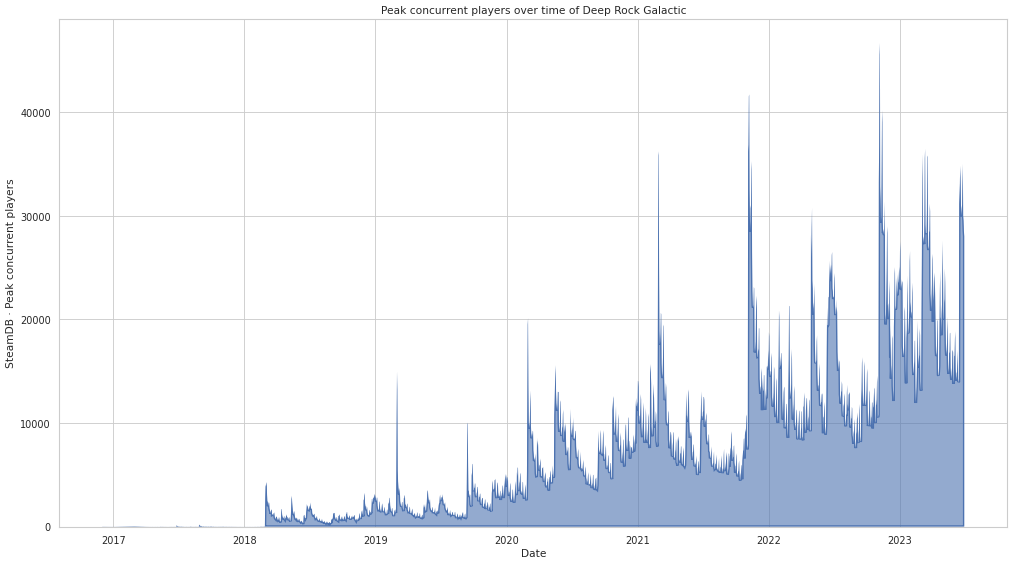

In [18]:
plot_concurrent_players("Deep Rock Galactic", df_deeprockgalactic).show()

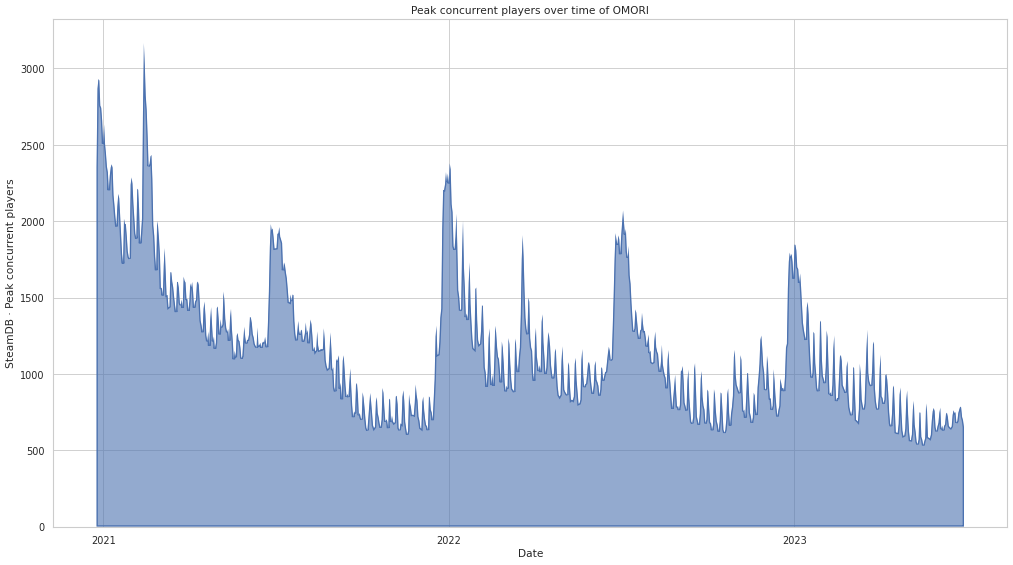

In [19]:
plot_concurrent_players("OMORI", df_omori).show()

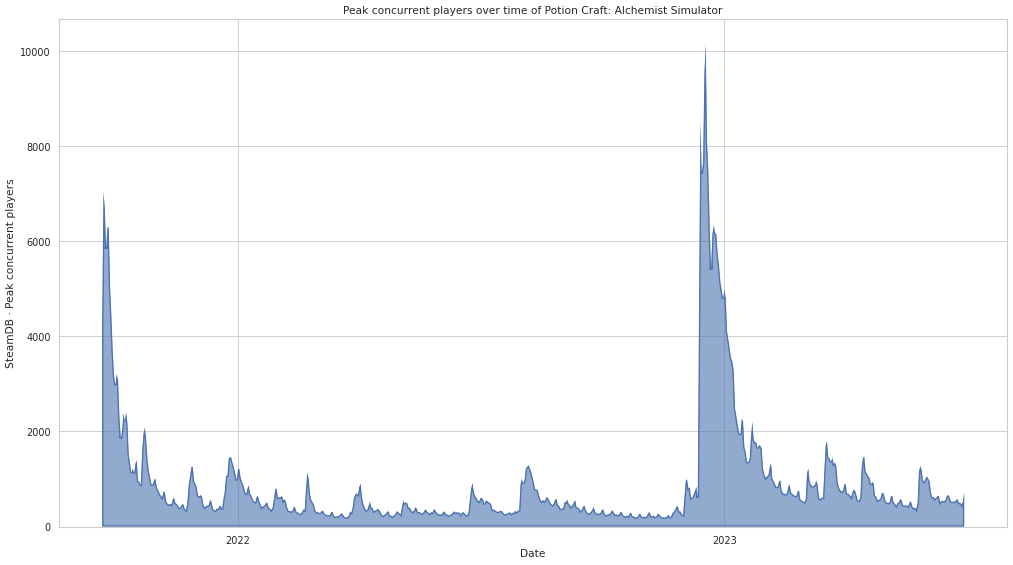

In [20]:
plot_concurrent_players("Potion Craft: Alchemist Simulator", df_potioncraft).show()

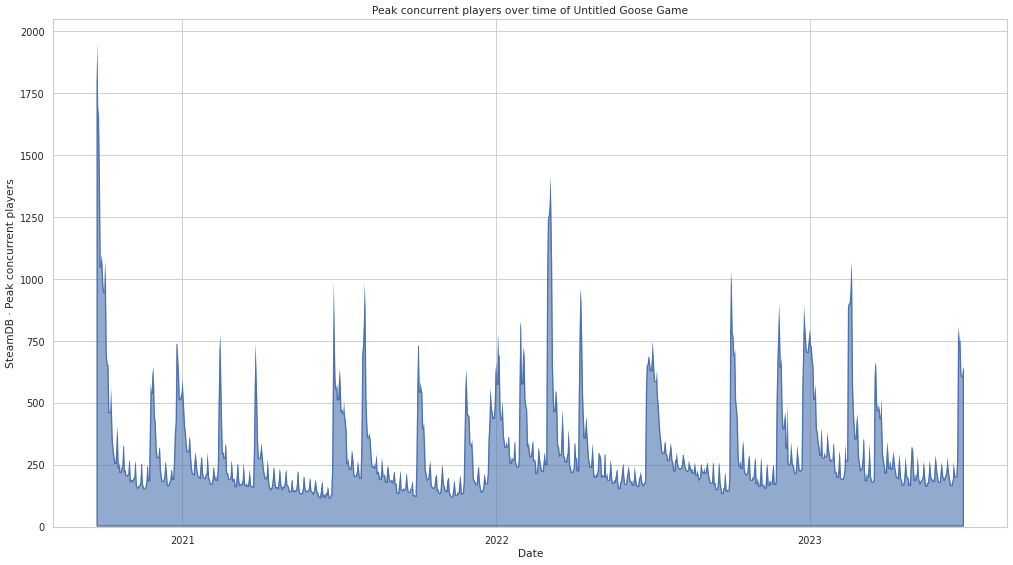

In [21]:
plot_concurrent_players("Untitled Goose Game", df_untitledgoosegame).show()

Si può osservare come il numero di giocatori concorrenti di ciascun videogioco formi grafici molto simili per tutti e quattro i dataset utilizzati:

- un grande picco iniziale (al momento del rilascio)
- piccoli picchi frequenti e periodici (il weekend)
- una baseline che diminuisce molto lentamente nel tempo (l'interesse che tende a calare nel tempo)
- vari picchi sparsi

Si realizza lo stesso grafico per Factorio, il prodotto senza le caratteristiche richieste per questo studio incluso deliberatamente per evidenziare la necessità di esse:

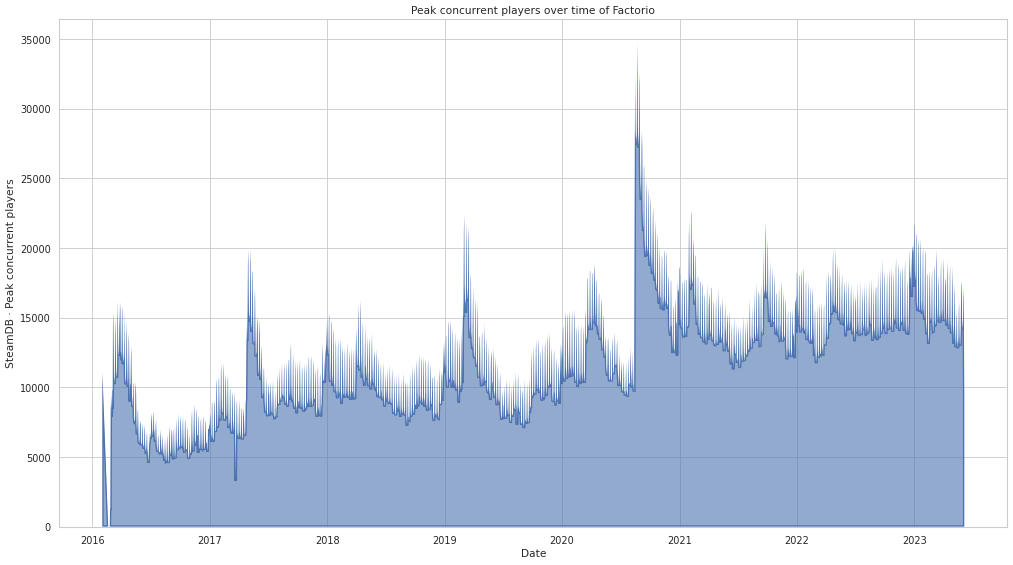

In [22]:
plot_concurrent_players("Factorio", df_factorio).show()

Si può osservare come:

- il picco iniziale ha una forma diversa dagli altri
- i picchi frequenti e periodici sono sempre presenti, ma molto più accentuati
- la baseline tende ad aumentare nel tempo invece che a diminuire
- i picchi sparsi sono quasi completamente assenti (fatta eccezione per il rilascio ufficiale del gioco nel 2021)

### Verifica dell'ipotesi del picco nel weekend

Si crea una visualizzazione che evidenzi chiaramente come i picchi periodici coincidano con il fine settimana.

In [23]:
class DoWFormatter(tick.Formatter):
    def __call__(self, x, pos=None):
        return {
            0: "Monday",
            1: "Tuesday",
            2: "Wednesday",
            3: "Thursday",
            4: "Friday",
            5: "Saturday",
            6: "Sunday"
        }[x]

In [24]:
def plot_weekend(name: str, df: pd.DataFrame) -> so.Plot:
    cdf = df[["SteamDB · Peak concurrent players"]]
    minimum = cdf.groupby(df.index.dayofweek).quantile(0.33).rename(columns={"SteamDB · Peak concurrent players": "SteamDB · 33rd percentile of peak concurrent players"})
    maximum = cdf.groupby(df.index.dayofweek).quantile(0.66).rename(columns={"SteamDB · Peak concurrent players": "SteamDB · 66th percentile of peak concurrent players"})
    both = utils.join_frames(minimum, maximum)

    return (
        so.Plot(
            data=both.reset_index(names="Day"),
            x="Day",
            ymin="SteamDB · 33rd percentile of peak concurrent players",
            ymax="SteamDB · 66th percentile of peak concurrent players",
        )
        .add(
            so.Range(
                linewidth=20,
            )
        )
        .add(
            so.Band()
        )
        .scale(
            x=so.Continuous()
            .tick(locator=mpld.DayLocator())
            .label(formatter=DoWFormatter()),
            y=so.Continuous()
            .tick(locator=tick.AutoLocator()),
        )
        .limit(
            y=(0, None),
        )
        .label(
            title=f"33rd to 66th percentile of concurrent players over day of week {name}",
        )
        .theme(theme)
    )


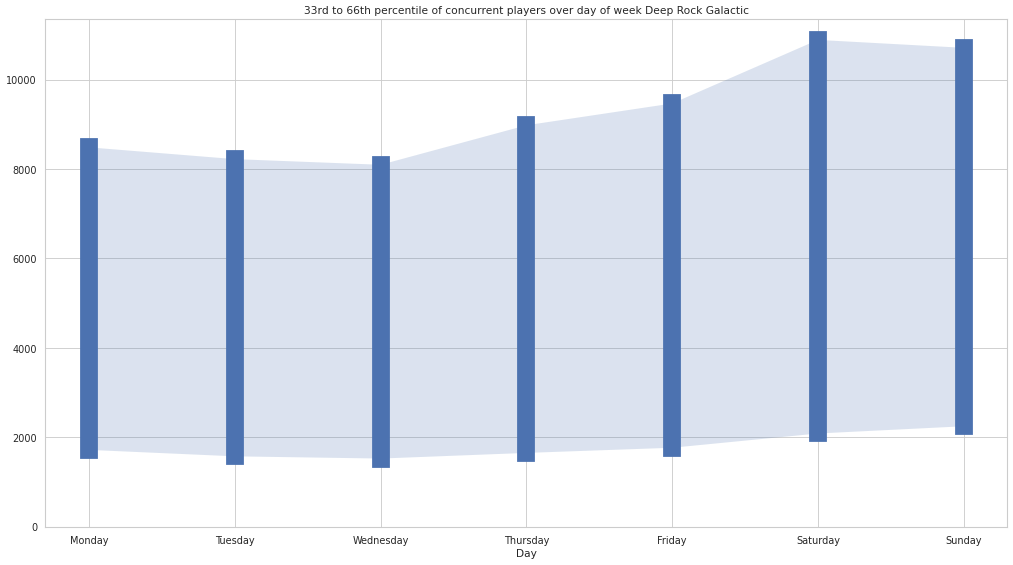

In [25]:
plot_weekend("Deep Rock Galactic", df_deeprockgalactic).show()

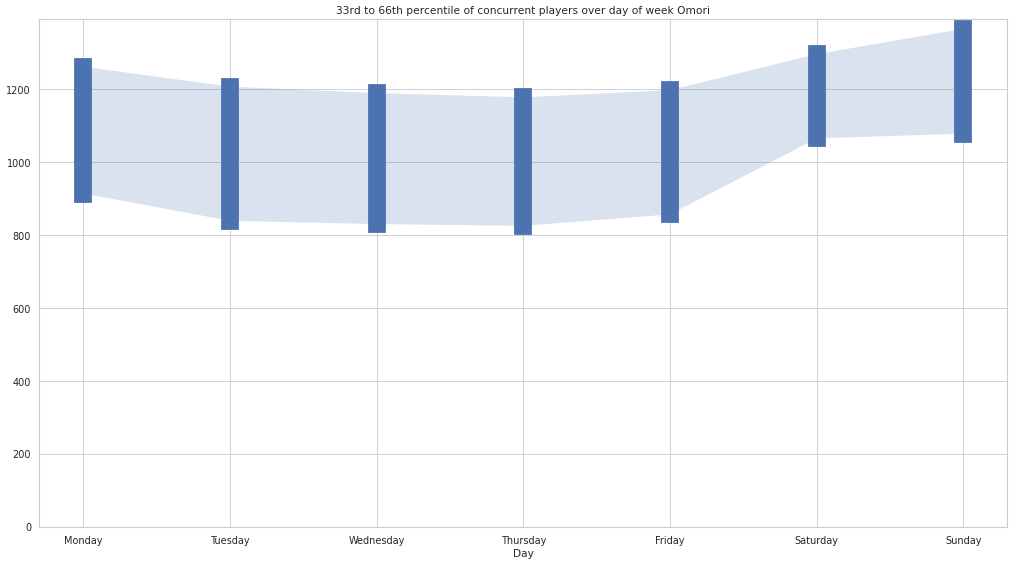

In [26]:
plot_weekend("Omori", df_omori).show()

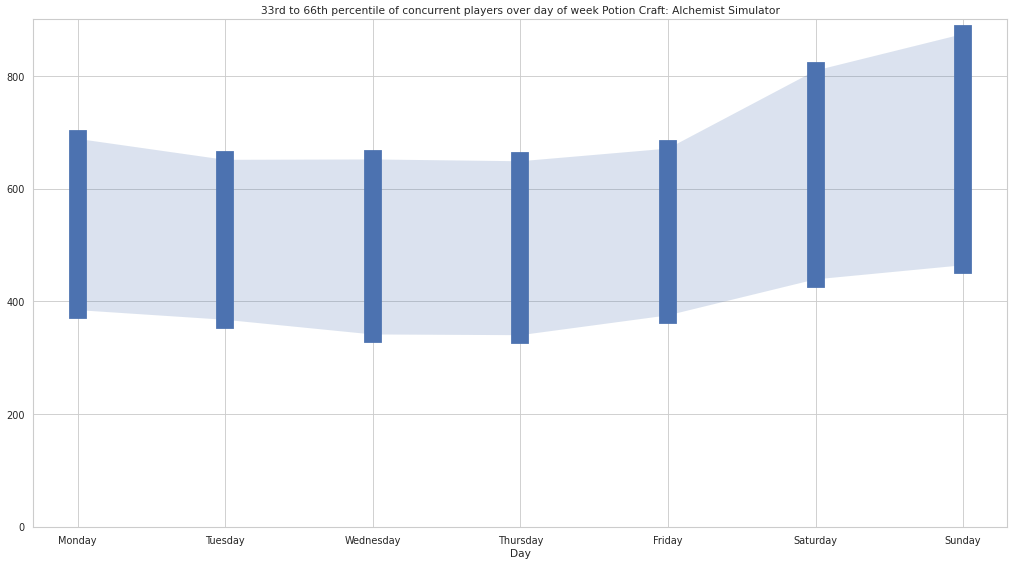

In [27]:
plot_weekend("Potion Craft: Alchemist Simulator", df_potioncraft).show()

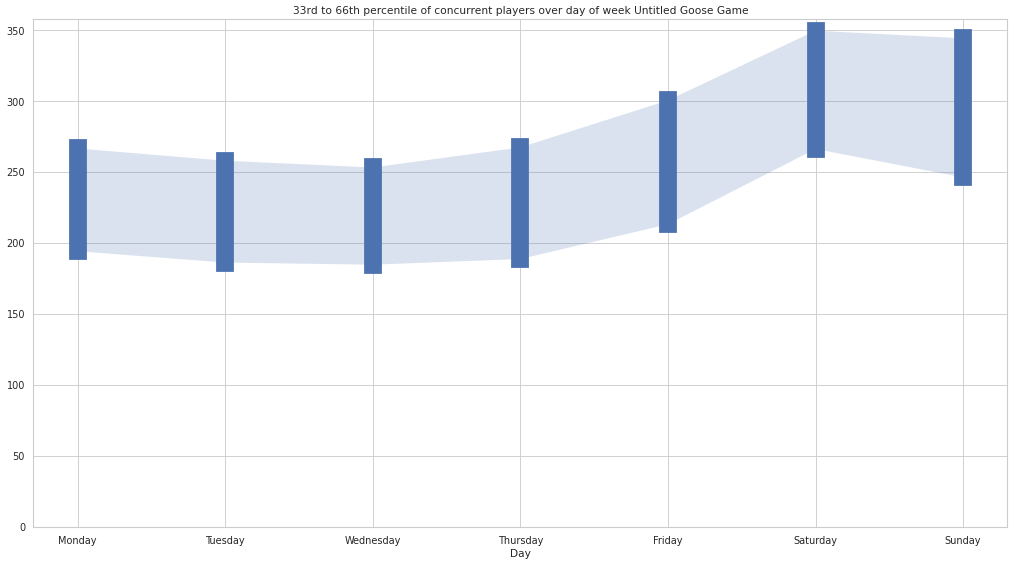

In [28]:
plot_weekend("Untitled Goose Game", df_untitledgoosegame).show()

Si può chiaramente osservare come il numero di giocatori concorrenti tenda ad essere più alto il sabato, la domenica, e talvolta il lunedì.

### Visualizzazione dello storico dei prezzi

Si ricreano con `seaborn` i grafici dello storico dei prezzi, sovrapponendo i prezzi immagazzinati da SteamDB con quelli di IsThereAnyDeal:


In [29]:
def plot_best_prices(name: str, df: pd.DataFrame) -> so.Plot:
    return (
        so.Plot(
            data=df.reset_index(names="Date")[[
                "Date",
                "SteamDB · Steam",
                "ITAD · Best Price",
            ]].melt(
                id_vars=["Date"],
                value_vars=[
                    "SteamDB · Steam",
                    "ITAD · Best Price",
                ],
                var_name="Data service",
                value_name="Price"
            ),
            x="Date",
            y="Price",
            color="Data service",
        )
        .add(
            so.Area(
                alpha=0.3,
            )
        )
        .scale(
            x=so.Temporal()
            .tick(locator=mpld.YearLocator()),
            y=so.Continuous()
            .tick(locator=tick.AutoLocator()),
        )
        .label(
            title=f"Prices over time of {name}",
        )
        .theme(theme)
    )


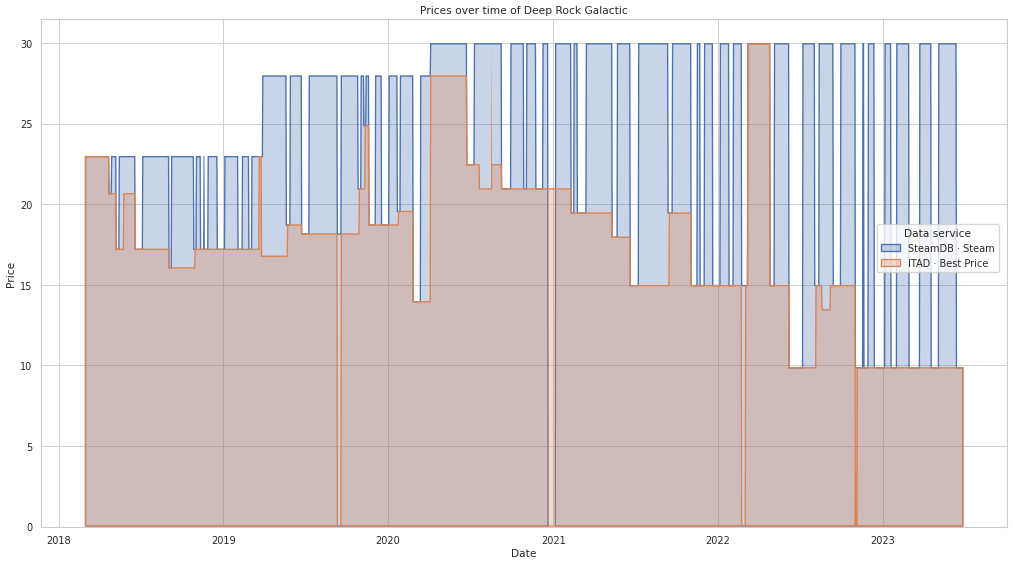

In [30]:
plot_best_prices("Deep Rock Galactic", df_deeprockgalactic).show()

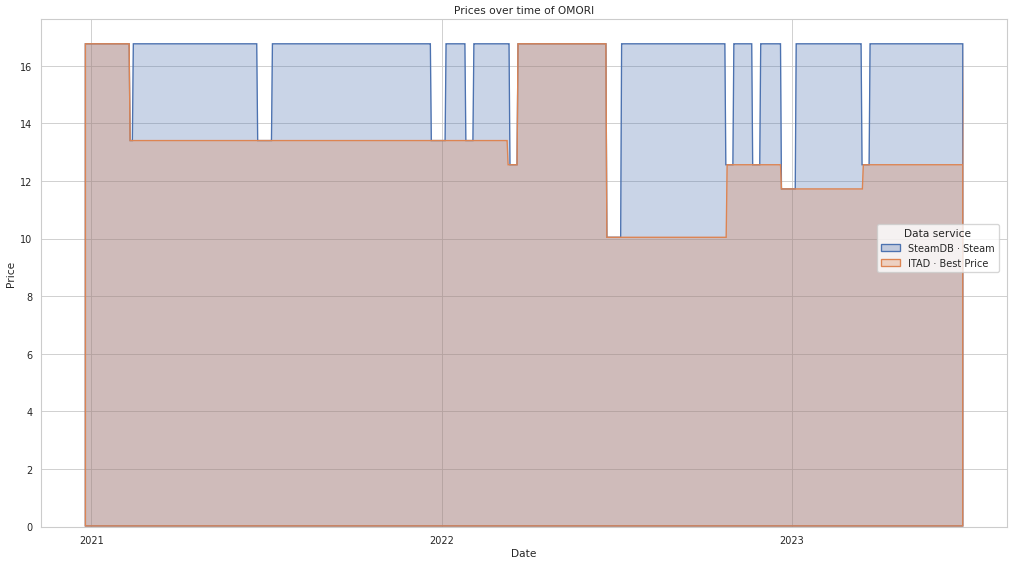

In [31]:
plot_best_prices("OMORI", df_omori).show()

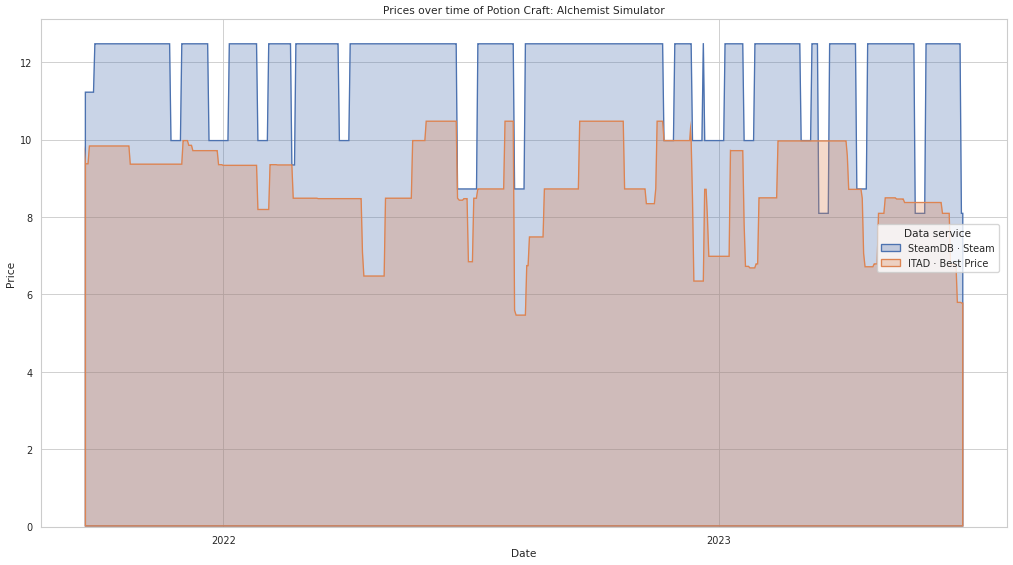

In [32]:
plot_best_prices("Potion Craft: Alchemist Simulator", df_potioncraft).show()

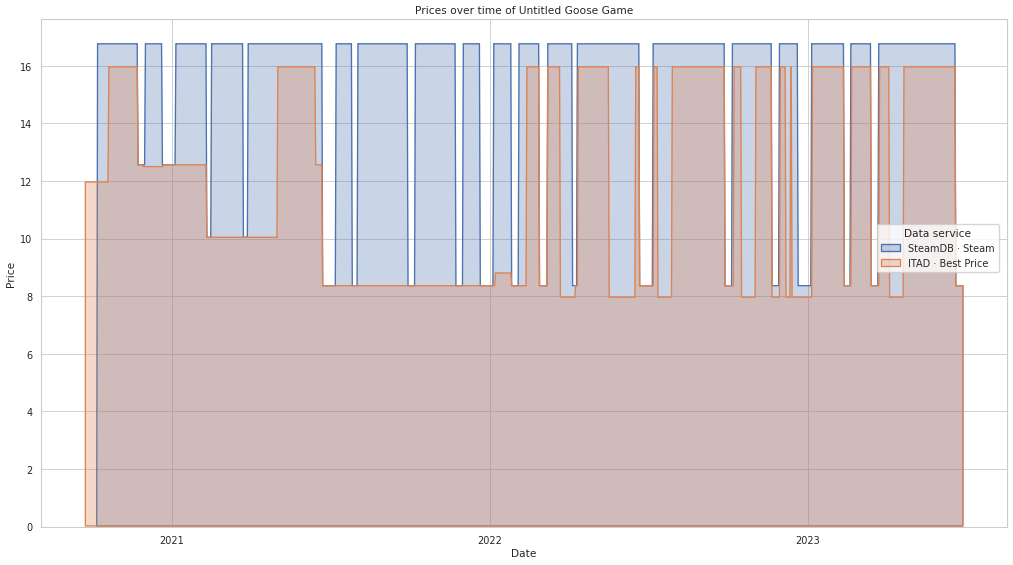

In [33]:
plot_best_prices("Untitled Goose Game", df_untitledgoosegame).show()

Si può osservare come:

- i prezzi tendano ad essere costanti o con piccoli aumenti nel tempo
- vi sono frequenti valli sparse coincidenti ai periodi in cui i prodotti sono in sconto
- IsThereAnyDeal abbia spesso prezzi minori rispetto a quelli ottenuti direttamente da Steam

Si realizza lo stesso grafico per Factorio, al fine di evidenziarne le differenze per l'ultima volta:

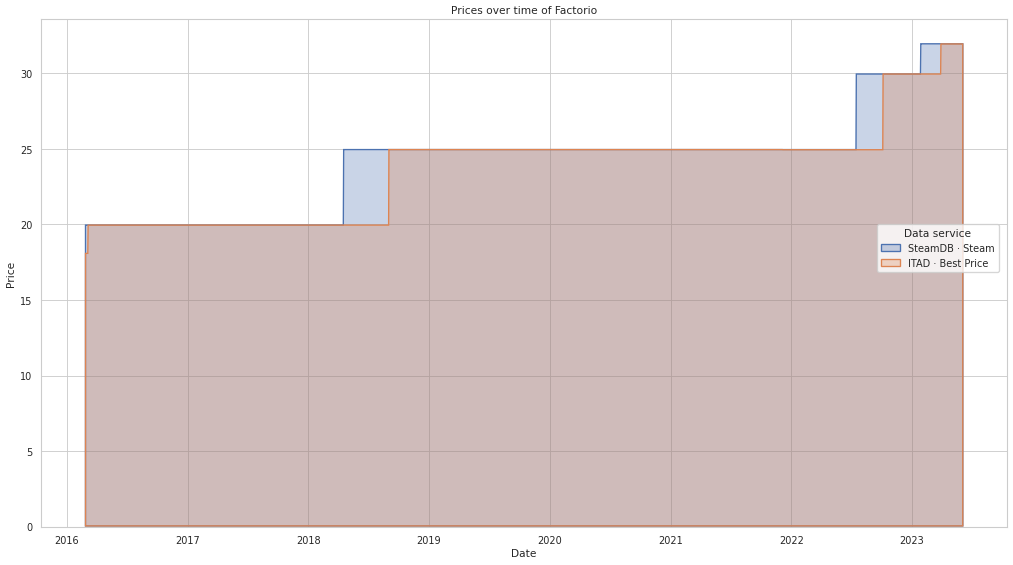

In [34]:
plot_best_prices("Factorio", df_factorio).show()

Si osserva che:

- il suo prezzo è sempre costante e con piccoli aumenti nel tempo
- non è presente nemmeno una valle; il prezzo è monotono crescente

Si scarta il dataset relativo a Factorio; non sarà più usato per il resto di questa relazione.

In [35]:
del df_factorio

### Sovrapposizione di giocatori concorrenti e prezzo

Si ipotizza che i picchi nel numero di giocatori concorrenti possano coincidere con periodi in cui il relativo videogioco è in sconto.

Si realizzano grafici che li comparano visivamente:

In [36]:
def plot_discount_overlap(df: pd.DataFrame) -> so.Plot:
    return (
        so.Plot(
            data=df.reset_index(names="Date")[[
                "Date",
                "SteamDB · Relative concurrent players",
                "SteamDB · Relative Steam price",
            ]].melt(
                id_vars=["Date"],
                value_vars=[
                    "SteamDB · Relative concurrent players",
                    "SteamDB · Relative Steam price",
                ],
                var_name="Data",
                value_name="·"
            ),
            x="Date",
            y="·",
        )
        .facet(
            row="Data",
        )
        .add(
            so.Area(
                alpha=0.6,
            )
        )
        .scale(
            x=so.Temporal()
            .tick(locator=mpld.YearLocator()),
            y=so.Continuous()
            .tick(locator=tick.AutoLocator()),
        )
        .theme(theme)
    )


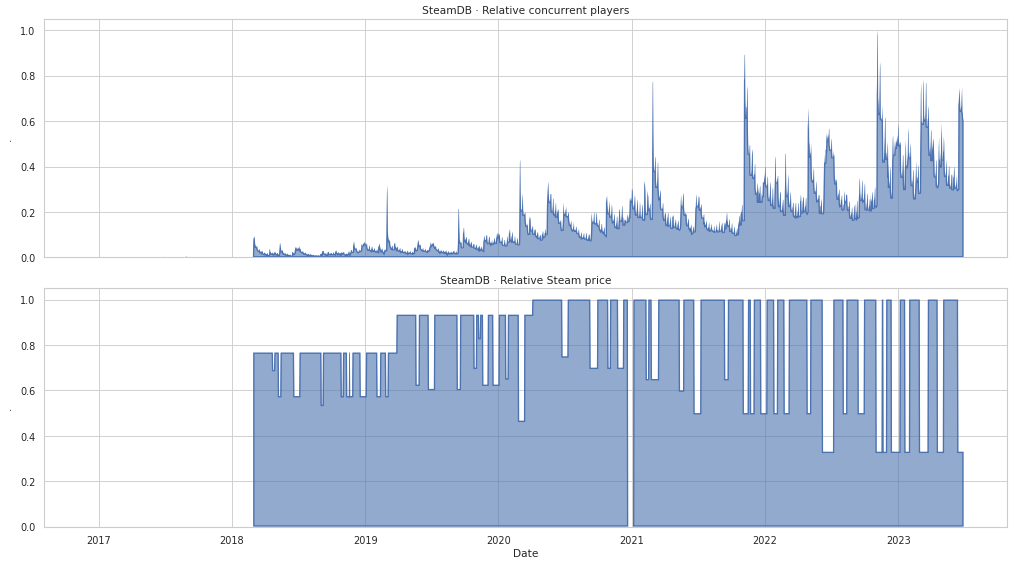

In [37]:
plot_discount_overlap(df_deeprockgalactic).show()

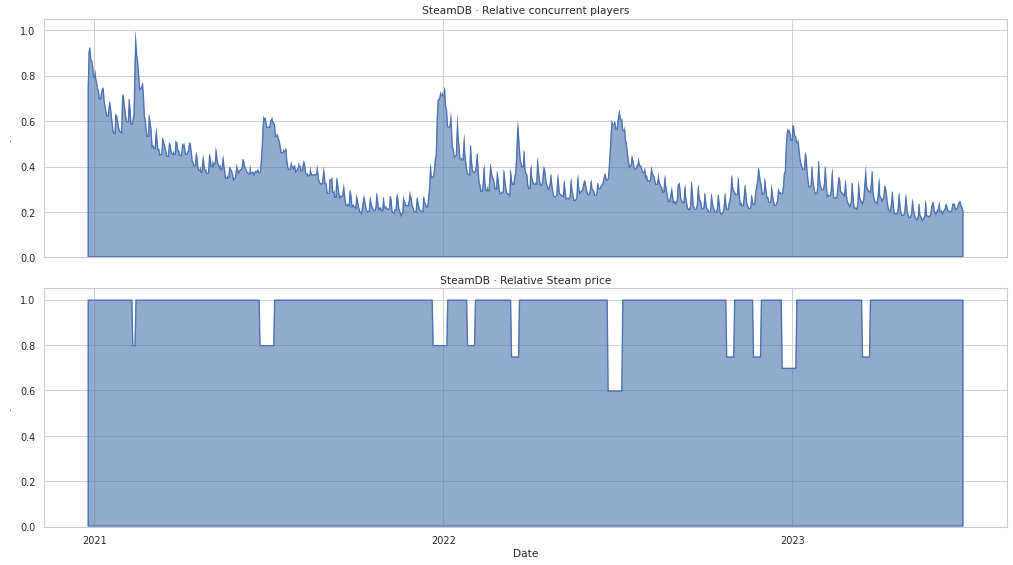

In [38]:
plot_discount_overlap(df_omori).show()

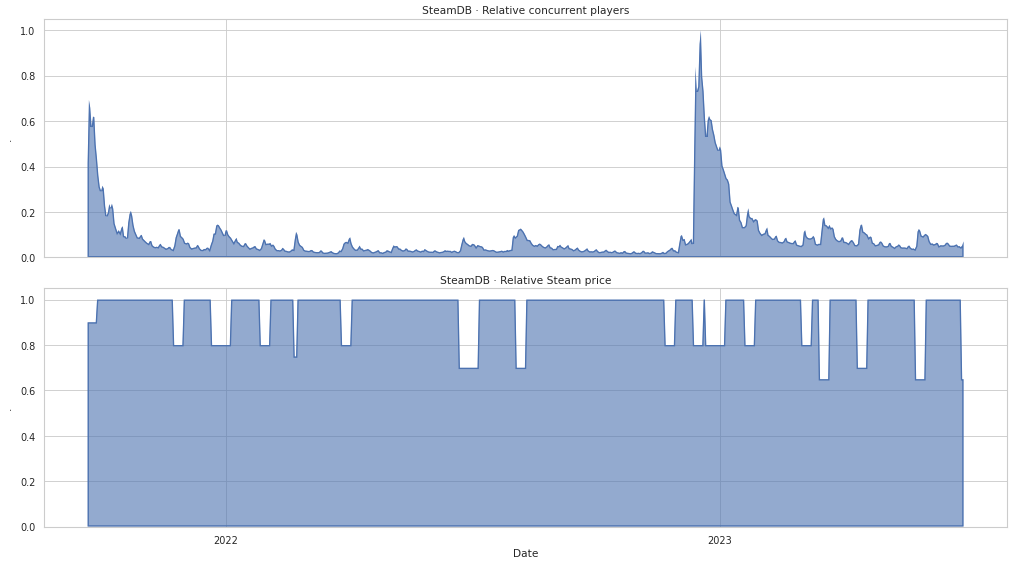

In [39]:
plot_discount_overlap(df_potioncraft).show()

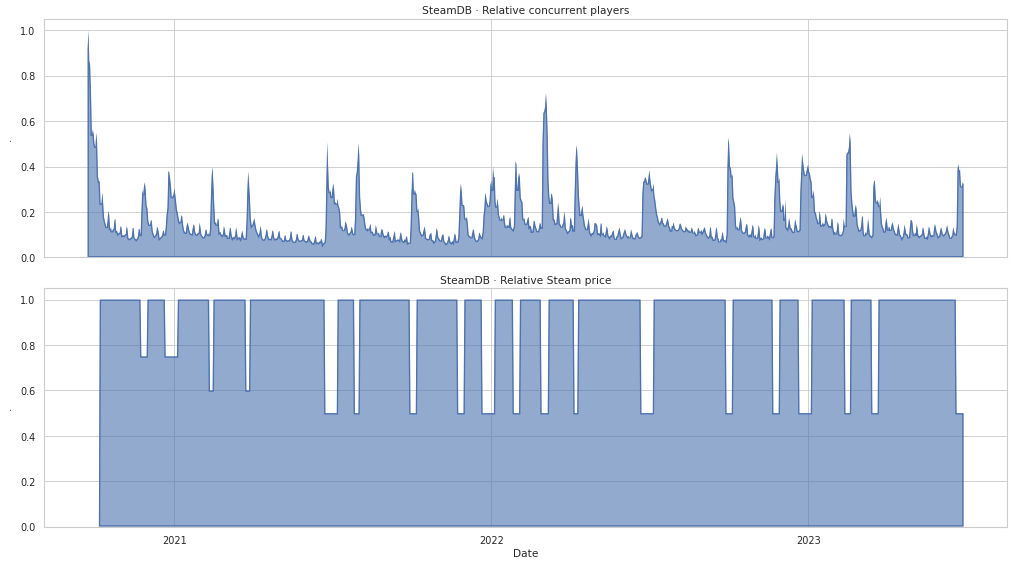

In [40]:
plot_discount_overlap(df_untitledgoosegame).show()

Si osserva che la maggior parte dei picchi coincidono con uno sconto.

### Coefficienti di correlazione dei precedenti valori

Si utilizza il metodo `pd.DataFrame.corr` per calcolare il coefficiente di correlazione di Pearson tra le due serie mostrate sui precedenti grafici:

In [41]:
df_deeprockgalactic.corr()["SteamDB · Relative concurrent players"]["SteamDB · Relative Steam price"]

-0.3117441811277705

In [42]:
df_omori.corr()["SteamDB · Relative concurrent players"]["SteamDB · Relative Steam price"]

-0.2742322328932592

In [43]:
df_potioncraft.corr()["SteamDB · Relative concurrent players"]["SteamDB · Relative Steam price"]

-0.3115367960263604

In [44]:
df_untitledgoosegame.corr()["SteamDB · Relative concurrent players"]["SteamDB · Relative Steam price"]

-0.783411760483506

Si osserva che in tutti i casi esiste una correlazione negativa tra le due serie, con intensità più o meno forte a seconda del prodotto.

### Sovrapposizione di giocatori concorrenti e annunci

Si ipotizza anche che i picchi possano essere corrispondenti alla pubblicazione di un annuncio da parte dello sviluppatore.

Si realizzano grafici che li comparano:

In [45]:
def plot_news_overlap(name: str, df: pd.DataFrame) -> so.Plot:
    cdf = df.reset_index(names="Date")[[
        "Date",
        "SteamDB · Relative concurrent players",
        "Steam · Is there News?",
    ]]
    cdf["Steam · Is there News?"] = cdf["Steam · Is there News?"].astype(int)

    return (
        so.Plot(
            data=cdf.melt(
                id_vars=["Date"],
                value_vars=[
                    "SteamDB · Relative concurrent players",
                    "Steam · Is there News?",
                ],
                var_name="Data",
                value_name="·"
            ),
            x="Date",
            y="·",
            color="Data",
        )
        .add(
            so.Area(
                alpha=0.6,
            )
        )
        .scale(
            x=so.Temporal()
            .tick(locator=mpld.YearLocator()),
            y=so.Continuous()
            .tick(locator=tick.AutoLocator()),
        )
        .label(
            title=f"Overlap of concurrent players and publishing of news for {name}",
        )
        .theme(theme)
    )

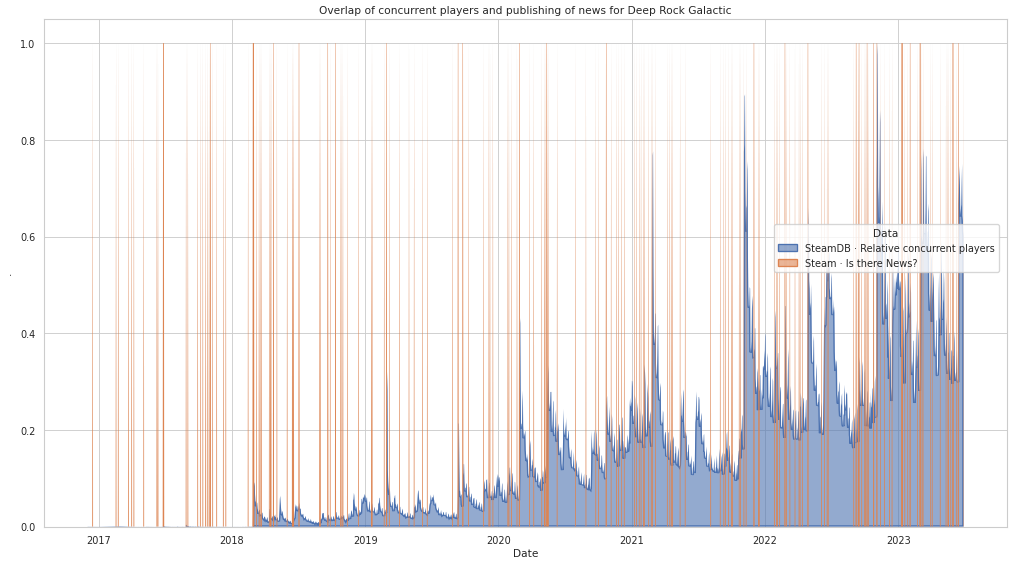

In [46]:
plot_news_overlap("Deep Rock Galactic", df_deeprockgalactic).show()

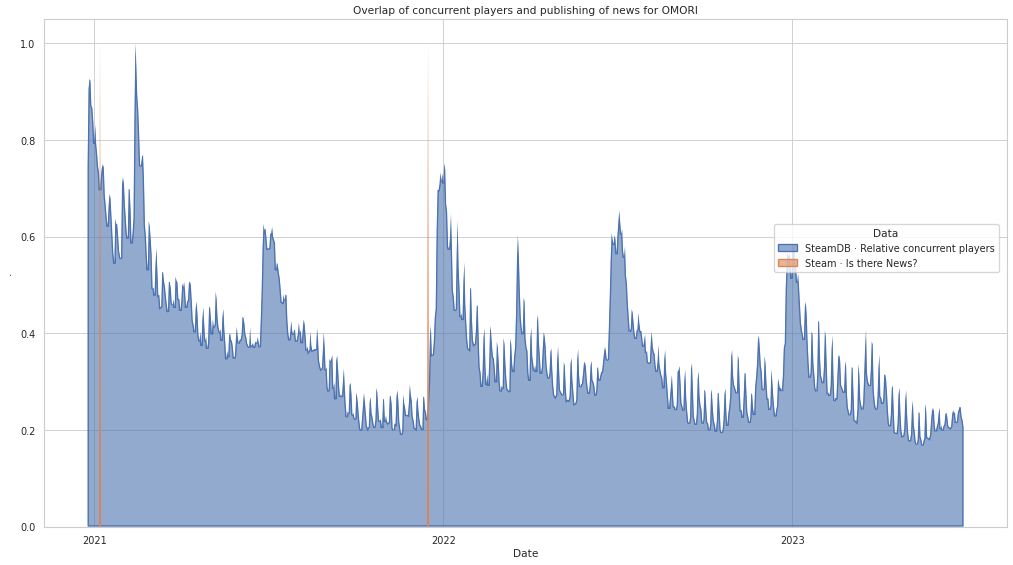

In [47]:
plot_news_overlap("OMORI", df_omori).show()

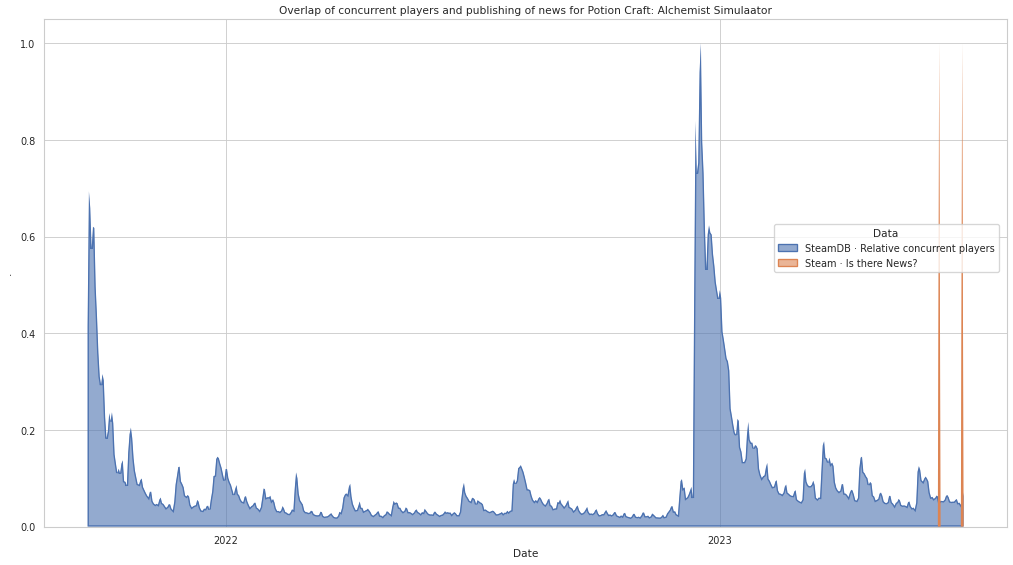

In [48]:
plot_news_overlap("Potion Craft: Alchemist Simulaator", df_potioncraft).show()

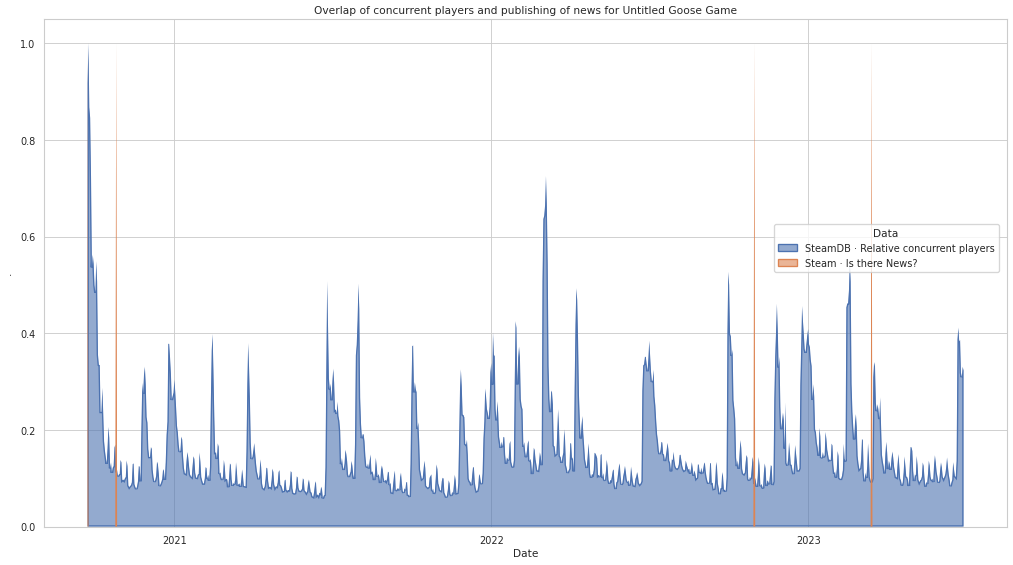

In [49]:
plot_news_overlap("Untitled Goose Game", df_untitledgoosegame).show()

Si osserva che alcuni dei picchi coincidono, ma solo raramente.

### Sovrapposizione di giocatori concorrenti e avvenimenti

Si ripete l'indagine, stavolta includendo anche le date di inizio sconto fra gli eventi:

In [50]:
def plot_happening_overlap(name: str, df: pd.DataFrame) -> so.Plot:
    cdf = df.reset_index(names="Date")[[
        "Date",
        "SteamDB · Relative concurrent players",
        "Cumulative · Is something happening?",
    ]]
    cdf["Cumulative · Is something happening?"] = cdf["Cumulative · Is something happening?"].astype(int)

    return (
        so.Plot(
            data=cdf.melt(
                id_vars=["Date"],
                value_vars=[
                    "SteamDB · Relative concurrent players",
                    "Cumulative · Is something happening?",
                ],
                var_name="Data",
                value_name="·"
            ),
            x="Date",
            y="·",
            color="Data",
        )
        .add(
            so.Area(
                alpha=0.6,
            )
        )
        .scale(
            x=so.Temporal()
            .tick(locator=mpld.YearLocator()),
            y=so.Continuous()
            .tick(locator=tick.AutoLocator()),
        )
        .label(
            title=f"Overlap of concurrent players and happenings for {name}",
        )
        .theme(theme)
    )


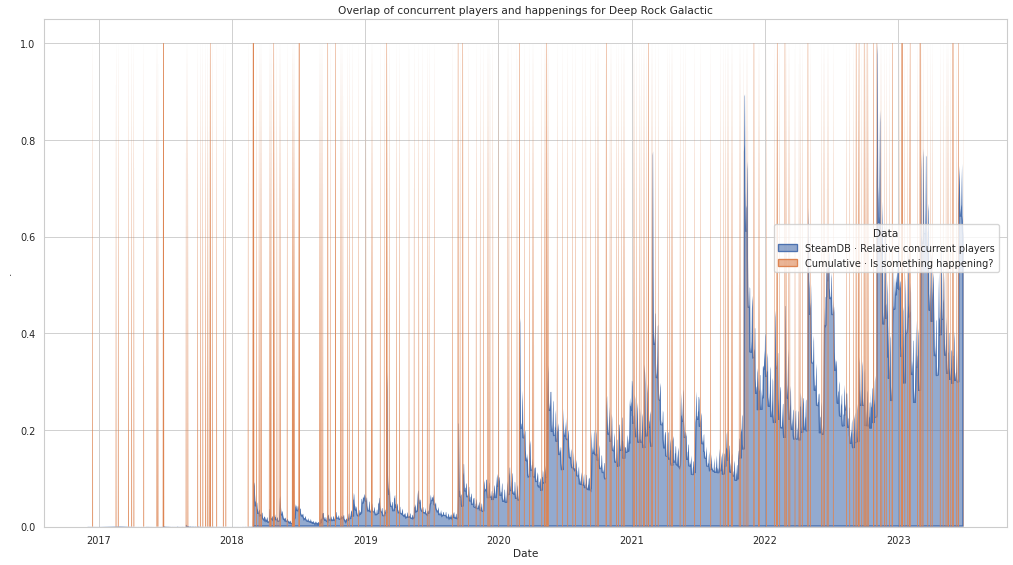

In [51]:
plot_happening_overlap("Deep Rock Galactic", df_deeprockgalactic).show()

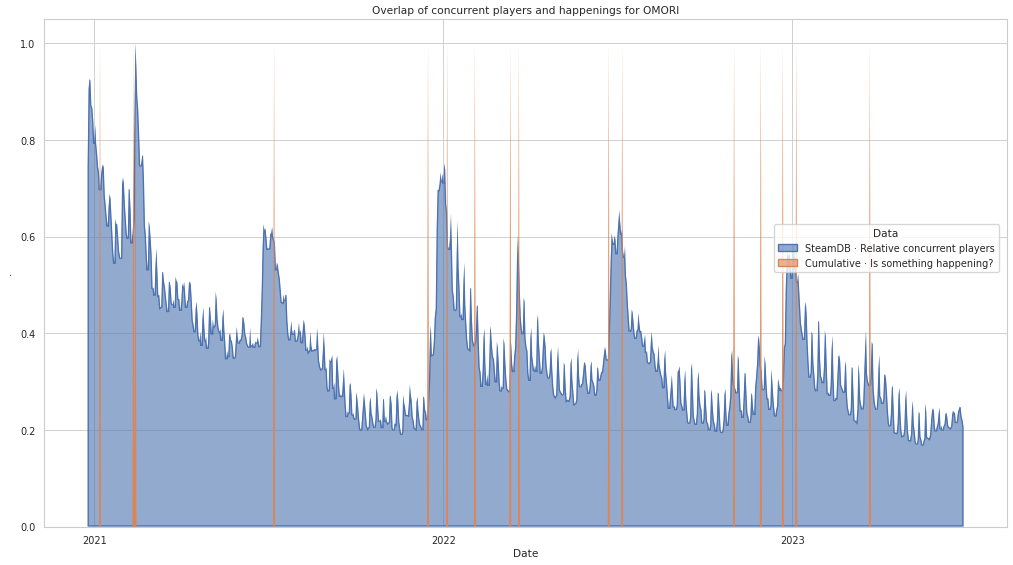

In [52]:
plot_happening_overlap("OMORI", df_omori).show()

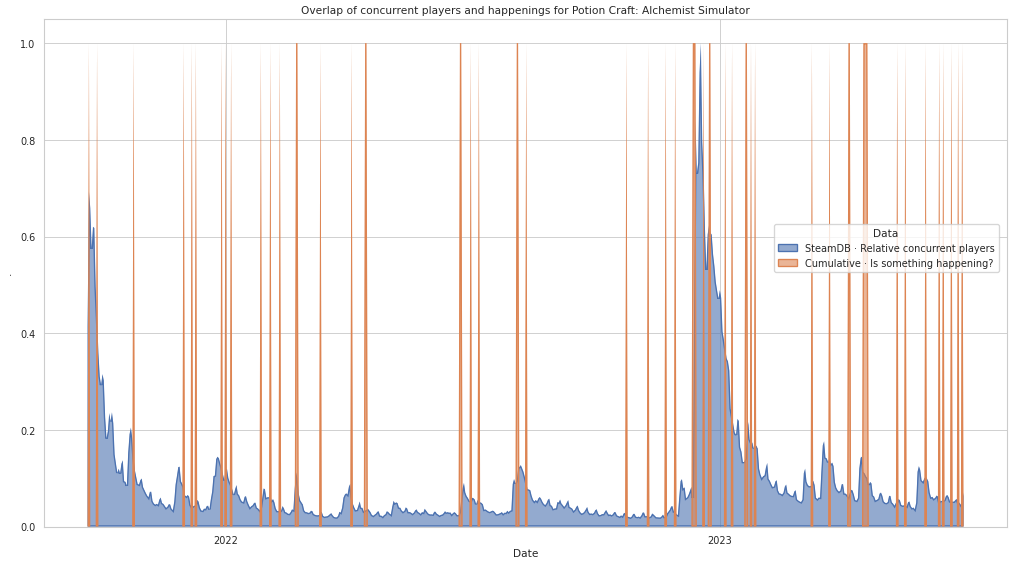

In [53]:
plot_happening_overlap("Potion Craft: Alchemist Simulator", df_potioncraft).show()

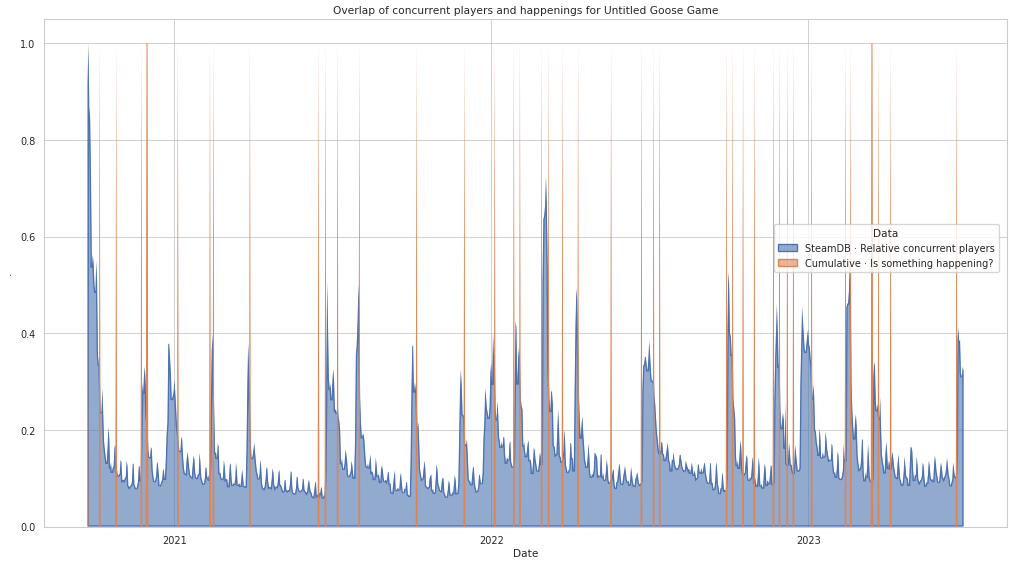

In [54]:
plot_happening_overlap("Untitled Goose Game", df_untitledgoosegame).show()

Si osserva come ora come ci sia quasi perfetta corrispondenza tra picchi ed eventi.

### Correlazione tra giocatori concorrenti e trend di ricerca

Si verifica la presenza di correlazione tra il numero di giocatori concorrenti e i trend di ricerca su Google.

Si creano grafici che sovrappongono le due misure:

In [55]:
def plot_trends_overlap(name: str, df: pd.DataFrame) -> so.Plot:
    return (
        so.Plot(
            data=df.reset_index(names="Date")[[
                "Date",
                "SteamDB · Relative concurrent players",
                "Google Trends · Score",
            ]].melt(
                id_vars=["Date"],
                value_vars=[
                    "SteamDB · Relative concurrent players",
                    "Google Trends · Score",
                ],
                var_name="Data",
                value_name="·"
            ),
            x="Date",
            y="·",
            color="Data",
        )
        .add(
            so.Area(
                alpha=0.3,
            )
        )
        .scale(
            x=so.Temporal()
            .tick(locator=mpld.YearLocator()),
            y=so.Continuous()
            .tick(locator=tick.AutoLocator()),
        )
        .label(
            title=f"Comparision of concurrent players and Google search trends for {name}",
        )
        .theme(theme)
    )


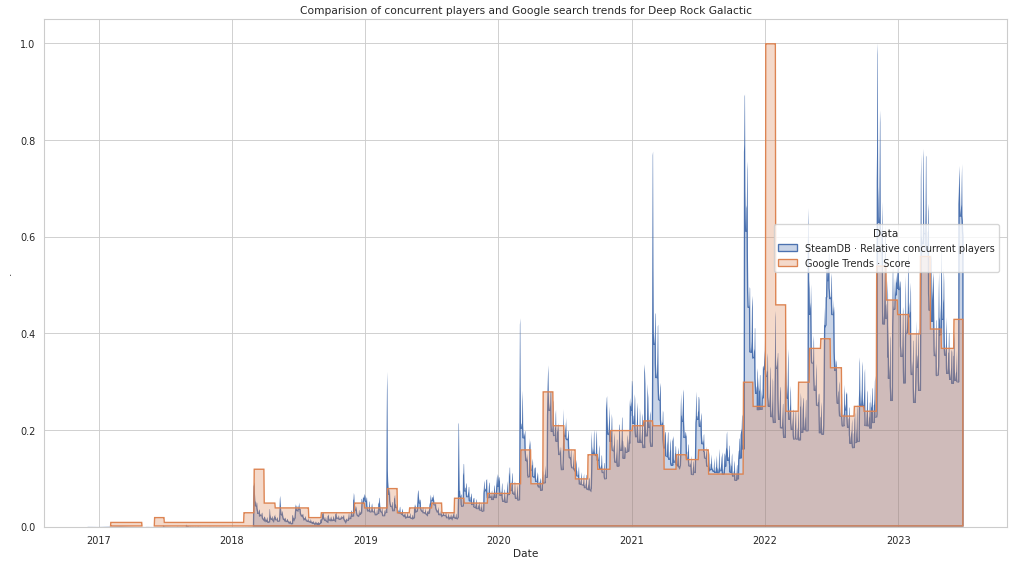

In [56]:
plot_trends_overlap("Deep Rock Galactic", df_deeprockgalactic).show()

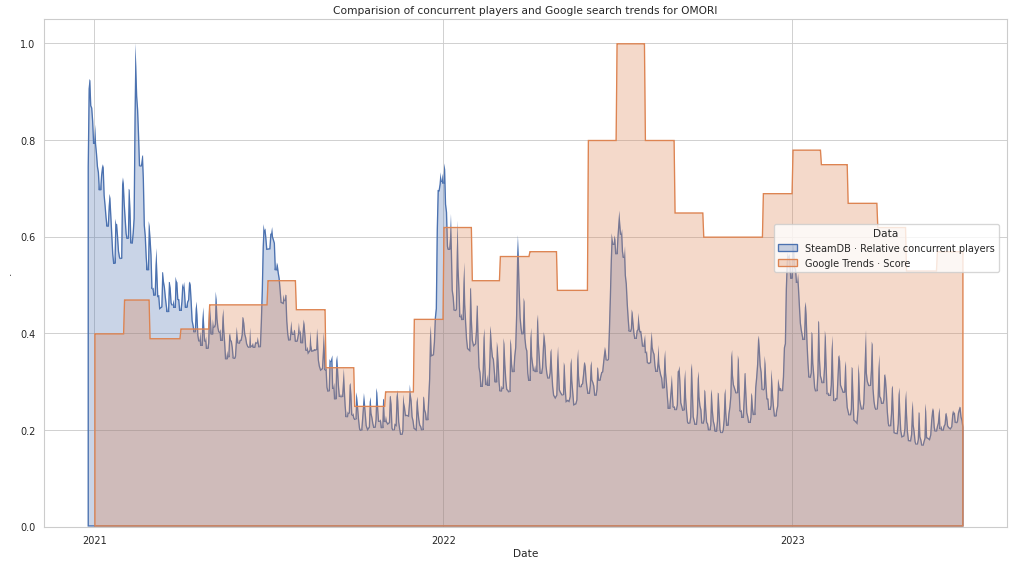

In [57]:
plot_trends_overlap("OMORI", df_omori).show()

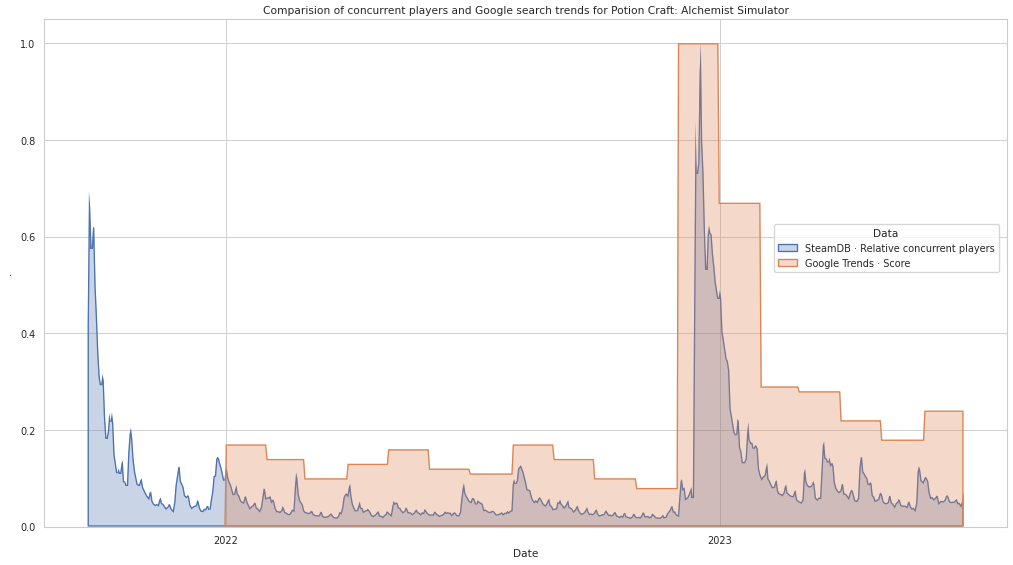

In [58]:
plot_trends_overlap("Potion Craft: Alchemist Simulator", df_potioncraft).show()

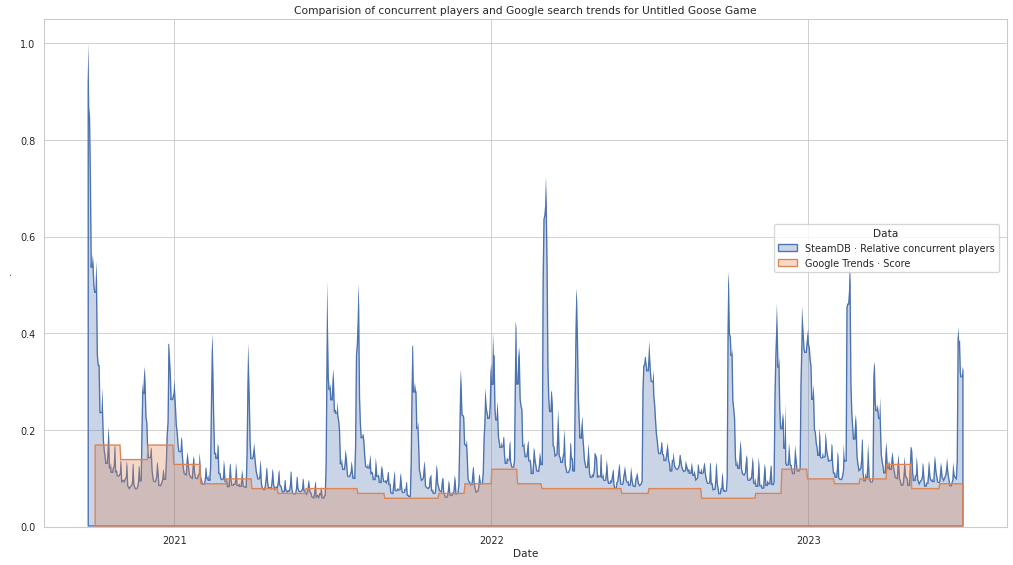

In [59]:
plot_trends_overlap("Untitled Goose Game", df_untitledgoosegame).show()

Visivamente, sembra esserci almeno una buona correlazione tra i due valori in due dei grafici creati, mentre essa sembra essere pessima in altri due.

Lo si verifica con il metodo `pd.DataFrame.corr`:

In [60]:
df_deeprockgalactic.corr()["SteamDB · Relative concurrent players"]["Google Trends · Score"]

0.7957309422777553

In [61]:
df_omori.corr()["SteamDB · Relative concurrent players"]["Google Trends · Score"]

-0.011662611466231525

In [62]:
df_potioncraft.corr()["SteamDB · Relative concurrent players"]["Google Trends · Score"]

0.6747104843444527

In [63]:
df_untitledgoosegame.corr()["SteamDB · Relative concurrent players"]["Google Trends · Score"]

0.12652683216472563

Infatti, si trova una correlazione fortemente positiva in due dei dataset, una molto debole nell'ultimo, e un valore insignificante nel secondo.

## Sviluppo di una funzione con buona correlazione rispetto al numero di giocatori concorrenti - `unimore_bda_3.post.add_scores`

In questa sezione si prova a sviluppare una funzione che sfrutta le informazioni sui prezzi, sugli annunci, e sui trend per predire il numero di giocatori concorrenti in ciascun momento, e poi la si correla al valore effettivo per verificarne l'efficacia.

I risultati della funzione per ciascun giorno vengono inseriti in-place nei `pd.DataFrame` attraverso la funzione `unimore_bda_3.post.add_scores`, che viene applicata immediatamente ai dataframe e poi di cui si procede a descriverne la costruzione.

In [64]:
from unimore_bda_3 import post

In [65]:
post.add_scores(df_deeprockgalactic)

,SteamDB · Peak concurrent players,SteamDB · Day average of concurrent players,SteamDB · Player count flags,SteamDB · Steam,SteamDB · Price flags,Google Trends · Score,Steam · Count of News tagged no_tags,Steam · Count of News tagged patchnotes,Steam · Count of News tagged hide_store,Steam · Count of News tagged ModAct_1401078964_1677758714_0,...,Cumulative · General happening score with base 1.11,Cumulative · Scaled general happening score with base 1.11,Cumulative · General happening score with base 1.12,Cumulative · Scaled general happening score with base 1.12,Cumulative · General happening score with base 1.13,Cumulative · Scaled general happening score with base 1.13,Cumulative · General happening score with base 1.14,Cumulative · Scaled general happening score with base 1.14,Cumulative · General happening score with base 1.15,Cumulative · Scaled general happening score with base 1.15
2016-12-01,11.0,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-12-02,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-12-03,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-12-04,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-12-05,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-25,35016.0,26276.0,NaN,9.89,NaN,0.43,0.0,0.0,0.0,0.0,...,0.352184,0.151439,0.321973,0.138448,0.294588,0.126673,0.269744,0.115990,0.247185,0.106289
2023-06-26,30017.0,22421.0,NaN,9.89,NaN,0.43,0.0,0.0,0.0,0.0,...,0.317283,0.136432,0.287476,0.123615,0.260698,0.112100,0.236617,0.101745,0.214943,0.092426
2023-06-27,29568.0,21949.0,NaN,9.89,NaN,0.43,0.0,0.0,0.0,0.0,...,0.285841,0.122912,0.256675,0.110370,0.230706,0.099204,0.207559,0.089250,0.186907,0.080370
2023-06-28,28539.0,21347.0,NaN,9.89,NaN,0.43,0.0,0.0,0.0,0.0,...,0.257514,0.110731,0.229174,0.098545,0.204165,0.087791,0.182069,0.078290,0.162528,0.069887


In [66]:
post.add_scores(df_omori)

,SteamDB · Peak concurrent players,SteamDB · Day average of concurrent players,SteamDB · Player count flags,SteamDB · Steam,SteamDB · Price flags,Google Trends · Score,Steam · Count of News tagged no_tags,ITAD · Best Price,ITAD · Best Regular Price,ITAD · Worst Regular Price,...,Cumulative · General happening score with base 1.11,Cumulative · Scaled general happening score with base 1.11,Cumulative · General happening score with base 1.12,Cumulative · Scaled general happening score with base 1.12,Cumulative · General happening score with base 1.13,Cumulative · Scaled general happening score with base 1.13,Cumulative · General happening score with base 1.14,Cumulative · Scaled general happening score with base 1.14,Cumulative · General happening score with base 1.15,Cumulative · Scaled general happening score with base 1.15
2020-12-25,2354.0,NaN,NaN,16.79,NaN,NaN,0.0,16.79,16.79,16.79,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
2020-12-26,2867.0,NaN,NaN,16.79,NaN,NaN,0.0,16.79,16.79,16.79,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
2020-12-27,2931.0,NaN,NaN,16.79,NaN,NaN,0.0,16.79,16.79,16.79,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
2020-12-28,2921.0,NaN,NaN,16.79,NaN,NaN,0.0,16.79,16.79,16.79,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
2020-12-29,2757.0,NaN,NaN,16.79,NaN,NaN,0.0,16.79,16.79,16.79,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-25,786.0,613.0,NaN,16.79,NaN,0.57,0.0,12.59,16.79,29.99,...,0.000055,0.000031,0.000024,0.000013,0.000010,0.000006,0.000004,0.000003,0.000002,1.122737e-06
2023-06-26,780.0,584.0,NaN,16.79,NaN,0.57,0.0,12.59,16.79,29.99,...,0.000049,0.000028,0.000021,0.000012,0.000009,0.000005,0.000004,0.000002,0.000002,9.762927e-07
2023-06-27,718.0,580.0,NaN,16.79,NaN,0.57,0.0,12.59,16.79,29.99,...,0.000045,0.000025,0.000019,0.000011,0.000008,0.000005,0.000003,0.000002,0.000001,8.489501e-07
2023-06-28,696.0,566.0,NaN,16.79,NaN,0.57,0.0,12.59,16.79,29.99,...,0.000040,0.000023,0.000017,0.000010,0.000007,0.000004,0.000003,0.000002,0.000001,7.382175e-07


In [67]:
post.add_scores(df_potioncraft)

,SteamDB · Peak concurrent players,SteamDB · Day average of concurrent players,SteamDB · Player count flags,SteamDB · Steam,SteamDB · Price flags,Google Trends · Score,Steam · Count of News tagged workshop,Steam · Count of News tagged ModAct_1428110219_1685546438_0,Steam · Count of News tagged mod_require_rereview,Steam · Count of News tagged mod_reviewed,...,Cumulative · General happening score with base 1.11,Cumulative · Scaled general happening score with base 1.11,Cumulative · General happening score with base 1.12,Cumulative · Scaled general happening score with base 1.12,Cumulative · General happening score with base 1.13,Cumulative · Scaled general happening score with base 1.13,Cumulative · General happening score with base 1.14,Cumulative · Scaled general happening score with base 1.14,Cumulative · General happening score with base 1.15,Cumulative · Scaled general happening score with base 1.15
2021-09-21,4202.0,NaN,NaN,11.24,NaN,NaN,0.0,0.0,0.0,0.0,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
2021-09-22,7046.0,NaN,NaN,11.24,NaN,NaN,0.0,0.0,0.0,0.0,...,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN
2021-09-23,6694.0,NaN,NaN,11.24,NaN,NaN,0.0,0.0,0.0,0.0,...,0.900901,NaN,0.892857,NaN,0.884956,NaN,0.877193,NaN,0.869565,NaN
2021-09-24,5837.0,NaN,NaN,11.24,NaN,NaN,0.0,0.0,0.0,0.0,...,0.811622,NaN,0.797194,NaN,0.783147,NaN,0.769468,NaN,0.756144,NaN
2021-09-25,6301.0,NaN,NaN,11.24,NaN,NaN,0.0,0.0,0.0,0.0,...,0.731191,NaN,0.711780,NaN,0.693050,NaN,0.674972,NaN,0.657516,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,497.0,385.0,NaN,12.49,NaN,0.24,0.0,0.0,0.0,0.0,...,1.000000,0.240000,1.000000,0.240000,1.000000,0.240000,1.000000,0.240000,1.000000,0.240000
2023-06-27,504.0,387.0,NaN,12.49,NaN,0.24,0.0,0.0,0.0,0.0,...,0.900901,0.216216,0.892857,0.214286,0.884956,0.212389,0.877193,0.210526,0.869565,0.208696
2023-06-28,457.0,367.0,NaN,12.49,NaN,0.24,0.0,0.0,0.0,0.0,...,0.811622,0.194789,0.797194,0.191327,0.783147,0.187955,0.769468,0.184672,0.756144,0.181474
2023-06-29,530.0,395.0,NaN,8.11,NaN,0.24,1.0,0.0,0.0,0.0,...,1.000000,0.240000,1.000000,0.240000,1.000000,0.240000,1.000000,0.240000,1.000000,0.240000


In [68]:
post.add_scores(df_untitledgoosegame)

,SteamDB · Peak concurrent players,SteamDB · Day average of concurrent players,SteamDB · Player count flags,SteamDB · Steam,SteamDB · Price flags,Google Trends · Score,Steam · Count of News tagged no_tags,Steam · Count of News tagged patchnotes,ITAD · Best Price,ITAD · Best Regular Price,...,Cumulative · General happening score with base 1.11,Cumulative · Scaled general happening score with base 1.11,Cumulative · General happening score with base 1.12,Cumulative · Scaled general happening score with base 1.12,Cumulative · General happening score with base 1.13,Cumulative · Scaled general happening score with base 1.13,Cumulative · General happening score with base 1.14,Cumulative · Scaled general happening score with base 1.14,Cumulative · General happening score with base 1.15,Cumulative · Scaled general happening score with base 1.15
2020-09-23,1788.0,NaN,NaN,0.00,NaN,NaN,2.0,0.0,11.99,15.99,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
2020-09-24,1951.0,NaN,NaN,0.00,NaN,NaN,0.0,0.0,11.99,15.99,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
2020-09-25,1692.0,NaN,NaN,0.00,NaN,NaN,0.0,0.0,11.99,15.99,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
2020-09-26,1649.0,NaN,NaN,0.00,NaN,NaN,0.0,0.0,11.99,15.99,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
2020-09-27,1406.0,NaN,NaN,0.00,NaN,NaN,0.0,0.0,11.99,15.99,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-25,753.0,504.0,NaN,8.39,NaN,0.09,0.0,0.0,8.39,15.99,...,0.658731,0.059286,0.635518,0.057197,0.613319,0.055199,0.592080,0.053287,0.571753,0.051458
2023-06-26,621.0,414.0,NaN,8.39,NaN,0.09,0.0,0.0,8.39,15.99,...,0.593451,0.053411,0.567427,0.051068,0.542760,0.048848,0.519369,0.046743,0.497177,0.044746
2023-06-27,603.0,405.0,NaN,8.39,NaN,0.09,0.0,0.0,8.39,15.99,...,0.534641,0.048118,0.506631,0.045597,0.480319,0.043229,0.455587,0.041003,0.432328,0.038909
2023-06-28,645.0,394.0,NaN,8.39,NaN,0.09,0.0,0.0,8.39,15.99,...,0.481658,0.043349,0.452349,0.040711,0.425061,0.038255,0.399637,0.035967,0.375937,0.033834


Si osserva che il numero di giocatori concorrenti tende a diminuire rapidamente in presenza di un picco; pertanto, si utilizza una funzione esponenziale decrescente come base di partenza.

Si definisce la funzione ricorsivamente nel seguente modo, cosicchè raggiunga il suo massimo in corrispondenza di ogni annuncio o sconto:

$$
x_{n+1} =
\begin{cases}
\begin{matrix}
1 & \mathrm{in\ corrispondenza\ di\ un\ annuncio}
\\
\\
1 & \mathrm{in\ corrispondenza\ di\ uno\ sconto}
\\
\\
\frac{x_n}{base} & \mathrm{in\ assenza\ di\ un\ avvenimento}
\\
\\
0 & \mathrm{inizialmente}
\end{matrix}
\end{cases}
$$


In Python, essa è definita così:

```python
score = pd.Series(dtype=float)
prev_date = None
for date, value in dataframe["Cumulative · Is something happening?"].items():
    if not prev_date:
        score[date] = 0
    elif value:
        score[date] = 1
    else:
        score[date] = score[prev_date] / base
    prev_date = date
dataframe[f"Cumulative · General happening score with base {base}"] = score
```

Si crea un grafico illustrativo per mostrare l'andamento della funzione (con una `base` arbitraria):

In [69]:
def plot_general_score_base_11(name: str, df: pd.DataFrame) -> so.Plot:
    return (
        so.Plot(
            data=df.reset_index(names="Date"),
            x="Date",
            y="Cumulative · General happening score with base 1.1",
        )
        .add(
            so.Area(
                alpha=0.6,
            )
        )
        .scale(
            x=so.Temporal()
            .tick(locator=mpld.YearLocator()),
            y=so.Continuous()
            .tick(locator=tick.AutoLocator()),
        )
        .label(
            title=f"Score base 1.1 over time for {name}",
        )
        .theme(theme)
    )

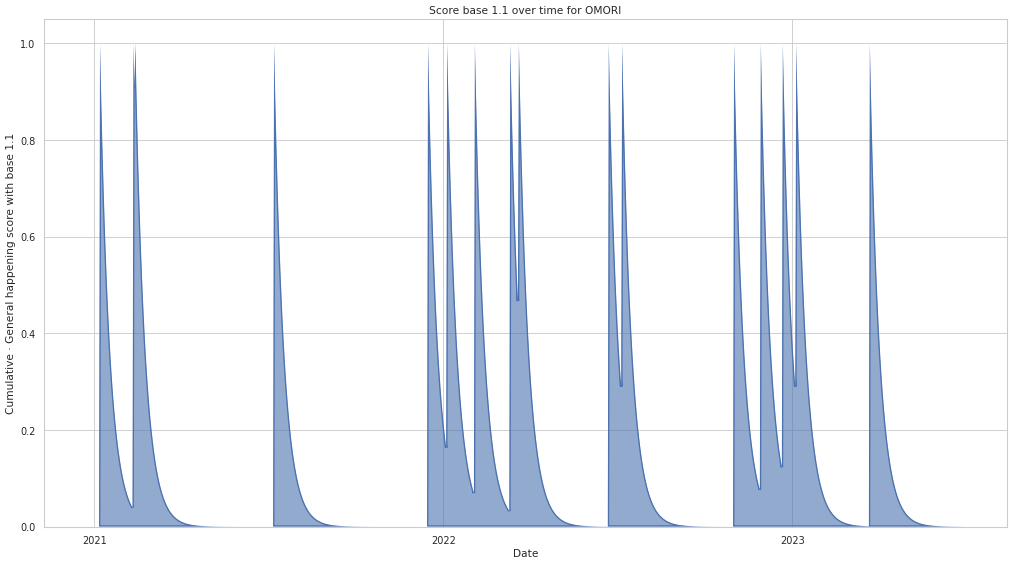

In [70]:
plot_general_score_base_11("OMORI", df_omori).show()

I picchi del numero dei giocatori concorrenti non raggiungono sempre lo stesso valore, però.

Ricordandocisi della vaga correlazione tra trend di ricerca e numero di giocatori, si utilizzano i valori a bassa risoluzione forniti da Google Trends per scalare i picchi:

```python
dataframe[f"Cumulative · Scaled general happening score with base {base}"] = dataframe[f"Cumulative · General happening score with base {base}"] * dataframe["Google Trends · Score"]
```

La funzione (ancora con `base` arbitraria) diventa quindi così:

In [71]:
def plot_scaled_score_base_11(name: str, df: pd.DataFrame) -> so.Plot:
    return (
        so.Plot(
            data=df.reset_index(names="Date"),
            x="Date",
            y="Cumulative · Scaled general happening score with base 1.1",
        )
        .add(
            so.Area(
                alpha=0.6,
            )
        )
        .scale(
            x=so.Temporal()
            .tick(locator=mpld.YearLocator()),
            y=so.Continuous()
            .tick(locator=tick.AutoLocator()),
        )
        .label(
            title=f"Scaled score base 1.1 over time for {name}",
        )
        .theme(theme)
    )

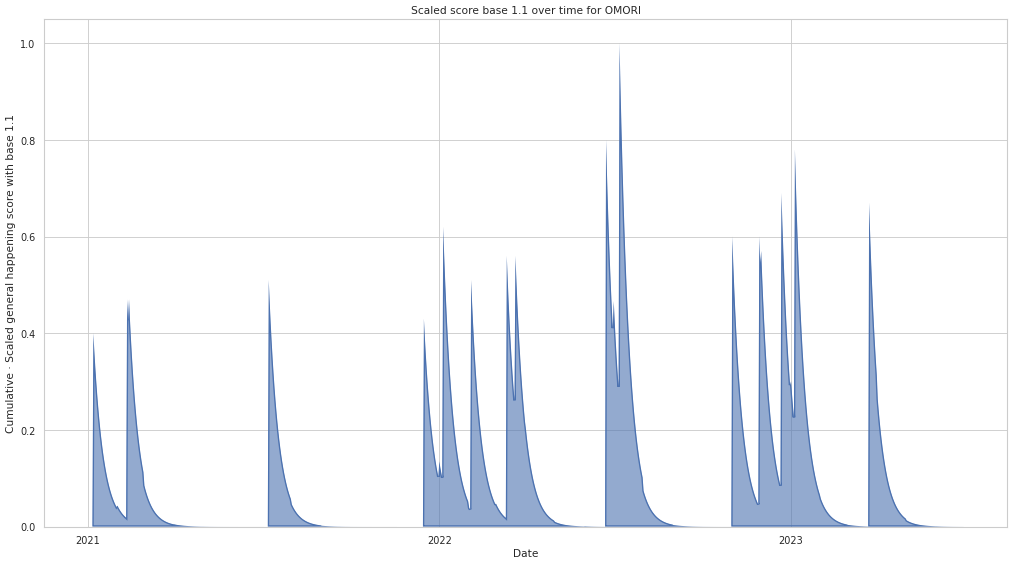

In [72]:
plot_scaled_score_base_11("OMORI", df_omori).show()

Infine, si vuole determinare il valore per il parametro `base` che porta a correlazione maggiore con l'altra funzione.

Per evitare overfitting, data la relativamente scarsa quantità di dati a disposizione in questo notebook, e mantenere il codice semplice, si selezionano alcuni valori arbitrari e si calcolano i valori della funzione per essi, per poi confrontare i risultati ottenuti e selezionare quello con correlazione media maggiore sui quattro dataset.

```python
# Si potrebbe ottimizzare con il metodo dicotomico, ma computando tutti i valori è possibile ottenere visualizzazioni migliori per il notebook
for base in [1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15]:
    ...
```

In [73]:
def get_mean_corr(v: float):
    print(f"{v} → ", end="")
    m = list(map(
            lambda df: df.corr()["SteamDB · Relative concurrent players"][f"Cumulative · Scaled general happening score with base {base}"],
            [df_deeprockgalactic, df_omori, df_potioncraft, df_untitledgoosegame]
        ))
    print(f"{m} / 4 = ", end="")
    print(f"{sum(m) / 4}")

for base in [1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15]:
    get_mean_corr(base)

1.01 → [0.8084812052361016, 0.22934744945493743, 0.6930843067988692, 0.14429448594068775] / 4 = 0.468801861857649
1.02 → [0.8149913743149819, 0.3213535609988236, 0.7042728453913346, 0.20773383320907401] / 4 = 0.5120879034785535
1.03 → [0.8165921749603406, 0.3610838107532645, 0.7116315932495408, 0.24446846951015075] / 4 = 0.5334440121183242
1.04 → [0.814480727191963, 0.37982813123145465, 0.7166506116254473, 0.2679859618840274] / 4 = 0.5447363579832231
1.05 → [0.8096650718457554, 0.3880384553231019, 0.7200659141569041, 0.2840477238248766] / 4 = 0.5504542912876594
1.06 → [0.8029531780197479, 0.3904114888546096, 0.7222852684904505, 0.29545345059913236] / 4 = 0.5527758464909851
1.07 → [0.794968935771353, 0.3893917527485946, 0.7235610714979362, 0.3037358754479714] / 4 = 0.5529144088664638
1.08 → [0.7861803665613096, 0.3863571158594142, 0.7240656730716245, 0.30981234003319114] / 4 = 0.5516038738813849
1.09 → [0.7769304482630098, 0.38212372604403716, 0.7239265140033933, 0.31426871939897816] / 

La base che massimizza la correlazione tra tutti i dataset è `1.07`.

Si mettono a confronto graficamente tre di queste funzioni, e la funzione "bersaglio":

In [74]:
def plot_functions_overlap(name: str, df: pd.DataFrame) -> so.Plot:
    return (
        so.Plot(
            data=df.reset_index(names="Date")[[
                "Date",
                "SteamDB · Relative concurrent players",
                "Cumulative · Scaled general happening score with base 1.02",
                "Cumulative · Scaled general happening score with base 1.07",
                "Cumulative · Scaled general happening score with base 1.15",
            ]].melt(
                id_vars=["Date"],
                value_vars=[
                    "SteamDB · Relative concurrent players",
                    "Cumulative · Scaled general happening score with base 1.02",
                    "Cumulative · Scaled general happening score with base 1.07",
                    "Cumulative · Scaled general happening score with base 1.15",
                ],
                var_name="Function",
                value_name="·"
            ),
            x="Date",
            y="·",
            color="Function",
        )
        .add(
            so.Area(
                alpha=0.2
            )
        )
        .scale(
            x=so.Temporal()
            .tick(locator=mpld.YearLocator()),
            y=so.Continuous()
            .tick(locator=tick.AutoLocator()),
        )
        .label(
            title=f"Comparision of functions {name}",
        )
        .theme(theme)
    )


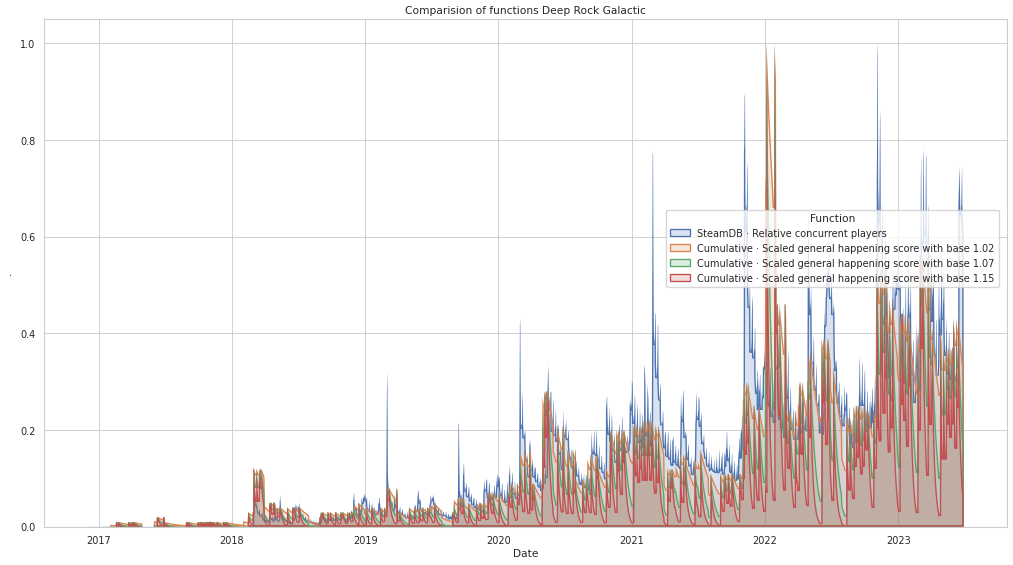

In [75]:
plot_functions_overlap("Deep Rock Galactic", df_deeprockgalactic).show()

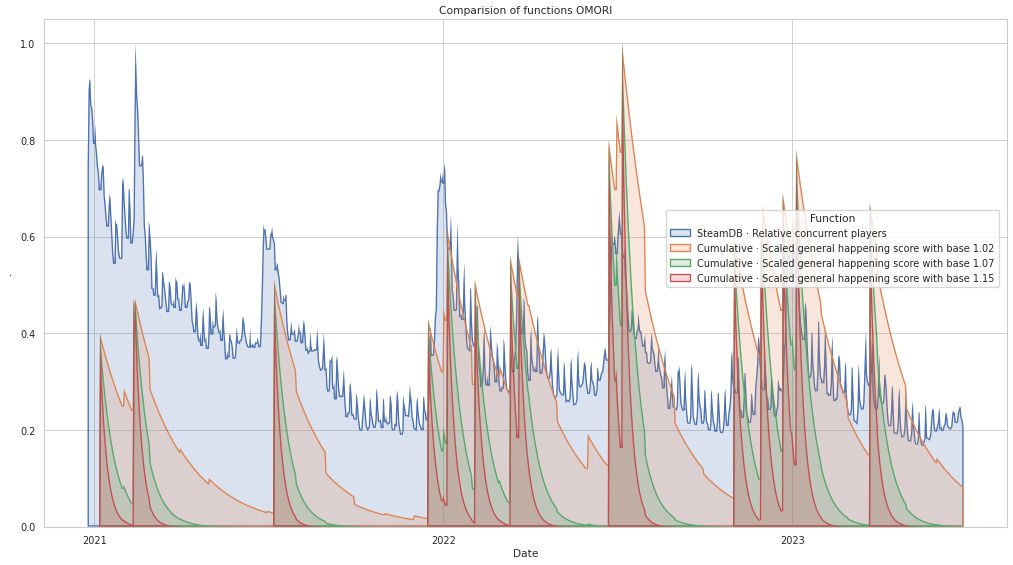

In [76]:
plot_functions_overlap("OMORI", df_omori).show()

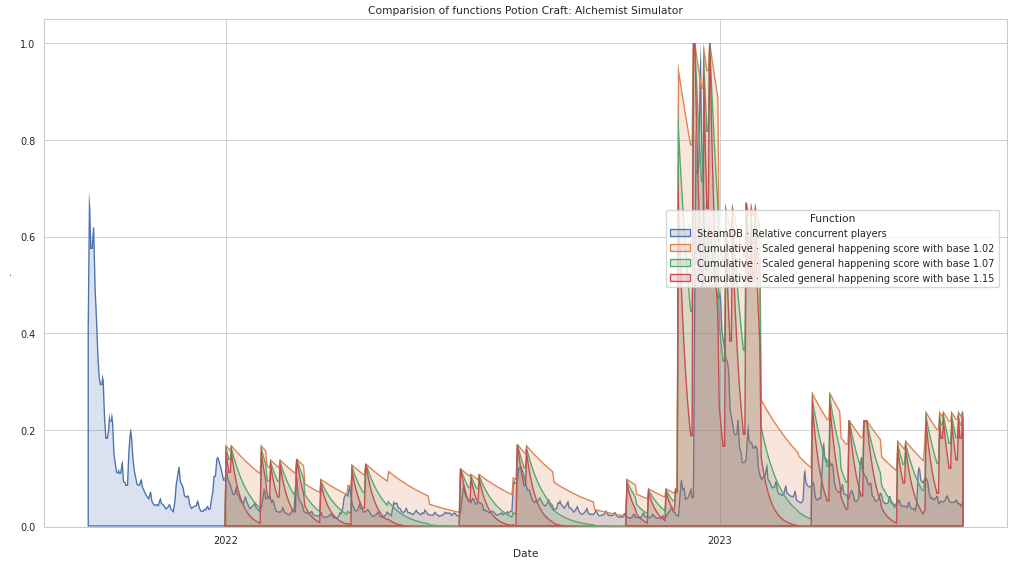

In [77]:
plot_functions_overlap("Potion Craft: Alchemist Simulator", df_potioncraft).show()

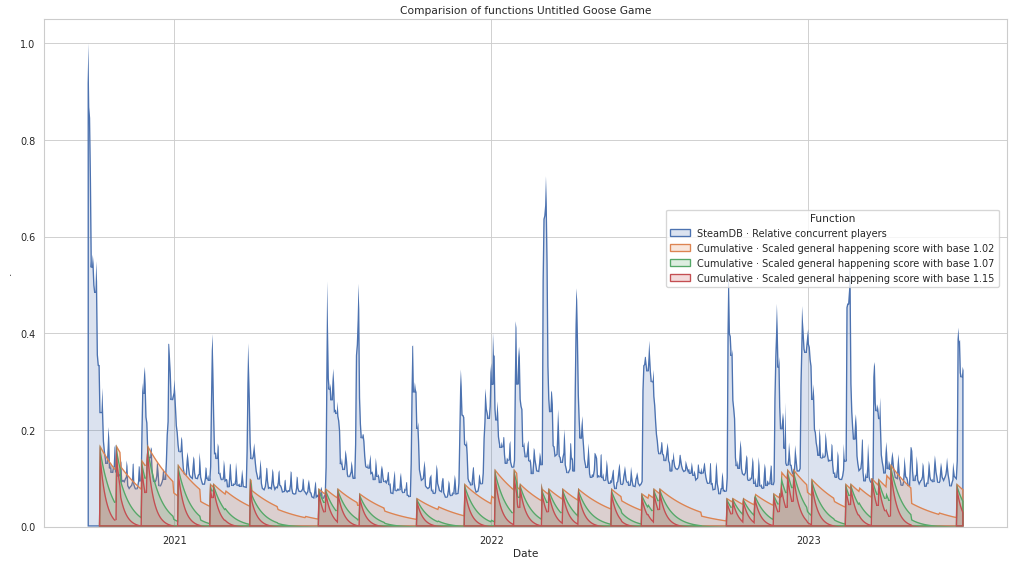

In [78]:
plot_functions_overlap("Untitled Goose Game", df_untitledgoosegame).show()

## Conclusioni

Il prezzo di un videogioco è correlato negativamente con il numero dei suoi giocatori concorrenti, come ipotizzato.

La pubblicazione di un annuncio spesso, ma non sempre, coincide con un incremento temporaneo nel numero dei giocatori.

La funzione modellata ha una correlazione di intensità che varia da debole a intensa in base al videogioco in questione.
